# GAN生成手写数字

## 导入数据

In [3]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


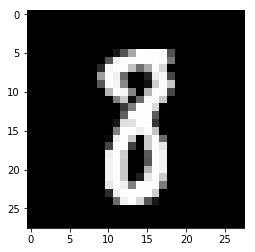

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

img = mnist.train.images[50]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## 构建模型

0. inputs
1. generator
2. descriminator
3. loss && optimizer

### Inputs

In [5]:
def get_inputs(real_size, noise_size):
    """
    真实图像tensor与噪声图像tensor
    """
    real_img  = tf.placeholder(tf.float32, [None, real_size ], name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    
    return real_img, noise_img

### Generator

In [6]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    """
    生成器
    
    noise_img: 生成器的输入
    n_units: 隐层单元个数
    out_dim: 生成器输出tensor的size，这里应该为32*32=784
    alpha: leaky ReLU系数
    """
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

### Discriminator

In [7]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    """
    判别器
    
    n_units: 隐层结点数量
    alpha: Leaky ReLU系数
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

###### 定义参数

In [8]:
# 定义参数
# 真实图像的size
img_size = mnist.train.images[0].shape[0]
# 传入给generator的噪声size
noise_size = 100
# 生成器隐层参数
g_units = 128
# 判别器隐层参数
d_units = 128
# leaky ReLU的参数
alpha = 0.01
# learning_rate
learning_rate = 0.001
# label smoothing
smooth = 0.1

###### 构建网络

In [9]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

### Loss

这里简单说一下Loss的计算方式，由于我们上面构建了两个神经网络：generator和discriminator，因此需要分别计算loss。

- discriminator 
> discriminator的目的在于对于给定的真图片，识别为真（1），对于generator生成的图片，识别为假（0），因此它的loss包含了真实图片的loss和生成器图片的loss两部分。
- generator 
> generator的目的在于让discriminator识别不出它的图片是假的，如果用1代表真，0代表假，那么generator生成的图片经过discriminator后要输出为1，因为generator想要骗过discriminator。

In [10]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)) * (1 - smooth))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

### Optimizer
由于我们在GAN里面一共训练了两个网络，所以需要分别定义优化函数。

In [11]:
train_vars = tf.trainable_variables()

# generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator中的tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## 训练

In [13]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []


# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)


# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # 记录各类loss值
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        # 存储checkpoints
        saver.save(sess, './checkpoints/generator.ckpt')

# 将sample的生成数据记录下来
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... Discriminator Loss: 0.0344(Real: 0.0120 + Fake: 0.0224)... Generator Loss: 4.3864
Epoch 2/300... Discriminator Loss: 1.1279(Real: 0.4532 + Fake: 0.6747)... Generator Loss: 1.4357
Epoch 3/300... Discriminator Loss: 1.3410(Real: 0.4140 + Fake: 0.9270)... Generator Loss: 2.8771
Epoch 4/300... Discriminator Loss: 0.8732(Real: 0.3776 + Fake: 0.4956)... Generator Loss: 1.9715
Epoch 5/300... Discriminator Loss: 1.6466(Real: 0.6259 + Fake: 1.0207)... Generator Loss: 0.7374
Epoch 6/300... Discriminator Loss: 1.3131(Real: 0.6315 + Fake: 0.6816)... Generator Loss: 0.9379
Epoch 7/300... Discriminator Loss: 1.3123(Real: 0.8446 + Fake: 0.4677)... Generator Loss: 1.0971
Epoch 8/300... Discriminator Loss: 1.1845(Real: 0.6951 + Fake: 0.4894)... Generator Loss: 1.3711
Epoch 9/300... Discriminator Loss: 1.1334(Real: 0.5782 + Fake: 0.5552)... Generator Loss: 2.1552
Epoch 10/300... Discriminator Loss: 1.1763(Real: 0.5541 + Fake: 0.6221)... Generator Loss: 1.2805
Epoch 11/300... Discriminator

Epoch 85/300... Discriminator Loss: 1.0287(Real: 0.5852 + Fake: 0.4435)... Generator Loss: 1.4233
Epoch 86/300... Discriminator Loss: 1.1143(Real: 0.5286 + Fake: 0.5857)... Generator Loss: 1.1044
Epoch 87/300... Discriminator Loss: 1.0712(Real: 0.3640 + Fake: 0.7072)... Generator Loss: 1.0101
Epoch 88/300... Discriminator Loss: 0.9670(Real: 0.4692 + Fake: 0.4978)... Generator Loss: 1.3495
Epoch 89/300... Discriminator Loss: 1.0648(Real: 0.4184 + Fake: 0.6464)... Generator Loss: 1.1098
Epoch 90/300... Discriminator Loss: 1.1273(Real: 0.4654 + Fake: 0.6619)... Generator Loss: 1.0404
Epoch 91/300... Discriminator Loss: 0.9244(Real: 0.4882 + Fake: 0.4362)... Generator Loss: 1.4380
Epoch 92/300... Discriminator Loss: 1.0714(Real: 0.5551 + Fake: 0.5163)... Generator Loss: 1.3404
Epoch 93/300... Discriminator Loss: 1.0157(Real: 0.5482 + Fake: 0.4675)... Generator Loss: 1.3541
Epoch 94/300... Discriminator Loss: 0.8536(Real: 0.2953 + Fake: 0.5583)... Generator Loss: 1.2060
Epoch 95/300... Disc

Epoch 168/300... Discriminator Loss: 0.9840(Real: 0.3893 + Fake: 0.5948)... Generator Loss: 1.0639
Epoch 169/300... Discriminator Loss: 1.0115(Real: 0.5290 + Fake: 0.4825)... Generator Loss: 1.2487
Epoch 170/300... Discriminator Loss: 0.9788(Real: 0.5539 + Fake: 0.4249)... Generator Loss: 1.5642
Epoch 171/300... Discriminator Loss: 0.9873(Real: 0.4366 + Fake: 0.5507)... Generator Loss: 1.2588
Epoch 172/300... Discriminator Loss: 0.9629(Real: 0.5831 + Fake: 0.3798)... Generator Loss: 1.5720
Epoch 173/300... Discriminator Loss: 0.8410(Real: 0.3867 + Fake: 0.4544)... Generator Loss: 1.5328
Epoch 174/300... Discriminator Loss: 0.8576(Real: 0.4944 + Fake: 0.3632)... Generator Loss: 1.6677
Epoch 175/300... Discriminator Loss: 0.8949(Real: 0.5882 + Fake: 0.3067)... Generator Loss: 1.7050
Epoch 176/300... Discriminator Loss: 0.9643(Real: 0.4161 + Fake: 0.5482)... Generator Loss: 1.2854
Epoch 177/300... Discriminator Loss: 0.9801(Real: 0.5267 + Fake: 0.4534)... Generator Loss: 1.4476
Epoch 178/

Epoch 251/300... Discriminator Loss: 0.9008(Real: 0.3528 + Fake: 0.5480)... Generator Loss: 1.3840
Epoch 252/300... Discriminator Loss: 0.9558(Real: 0.5301 + Fake: 0.4257)... Generator Loss: 1.6099
Epoch 253/300... Discriminator Loss: 0.8225(Real: 0.4931 + Fake: 0.3293)... Generator Loss: 1.7121
Epoch 254/300... Discriminator Loss: 0.8202(Real: 0.3741 + Fake: 0.4462)... Generator Loss: 1.9111
Epoch 255/300... Discriminator Loss: 0.7632(Real: 0.3520 + Fake: 0.4111)... Generator Loss: 1.5370
Epoch 256/300... Discriminator Loss: 0.9111(Real: 0.3706 + Fake: 0.5405)... Generator Loss: 1.2621
Epoch 257/300... Discriminator Loss: 0.7260(Real: 0.3357 + Fake: 0.3902)... Generator Loss: 1.5092
Epoch 258/300... Discriminator Loss: 0.7670(Real: 0.2667 + Fake: 0.5004)... Generator Loss: 1.3049
Epoch 259/300... Discriminator Loss: 0.9310(Real: 0.4747 + Fake: 0.4563)... Generator Loss: 1.5882
Epoch 260/300... Discriminator Loss: 0.8703(Real: 0.2943 + Fake: 0.5760)... Generator Loss: 1.3257
Epoch 261/

## 分析

### 绘制loss曲线

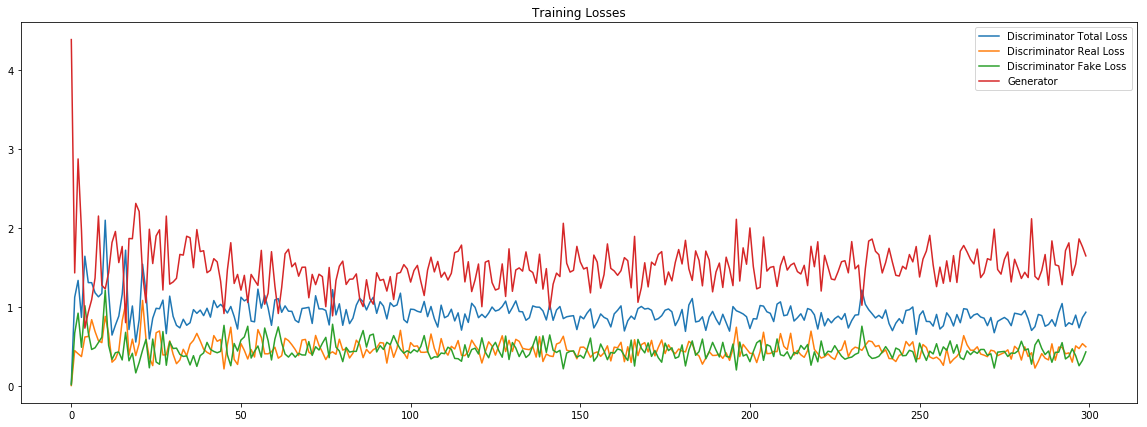

In [14]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Total Loss')
plt.plot(losses.T[1], label='Discriminator Real Loss')
plt.plot(losses.T[2], label='Discriminator Fake Loss')
plt.plot(losses.T[3], label='Generator')
plt.title("Training Losses")
plt.legend()

### 显示图像

In [15]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [16]:
def view_samples(epoch, samples):
    """
    epoch代表第几次迭代的图像
    samples为我们的采样结果
    """
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]):
        # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

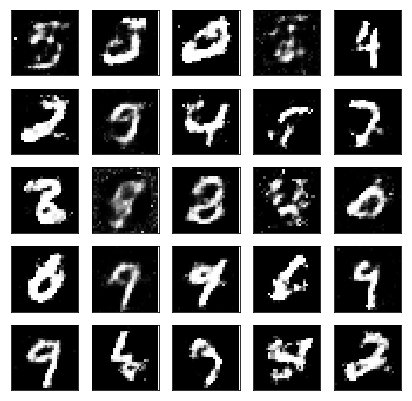

In [17]:
_ = view_samples(-1, samples) # 显示最后一轮的outputs

### 显示整个生成过程图片

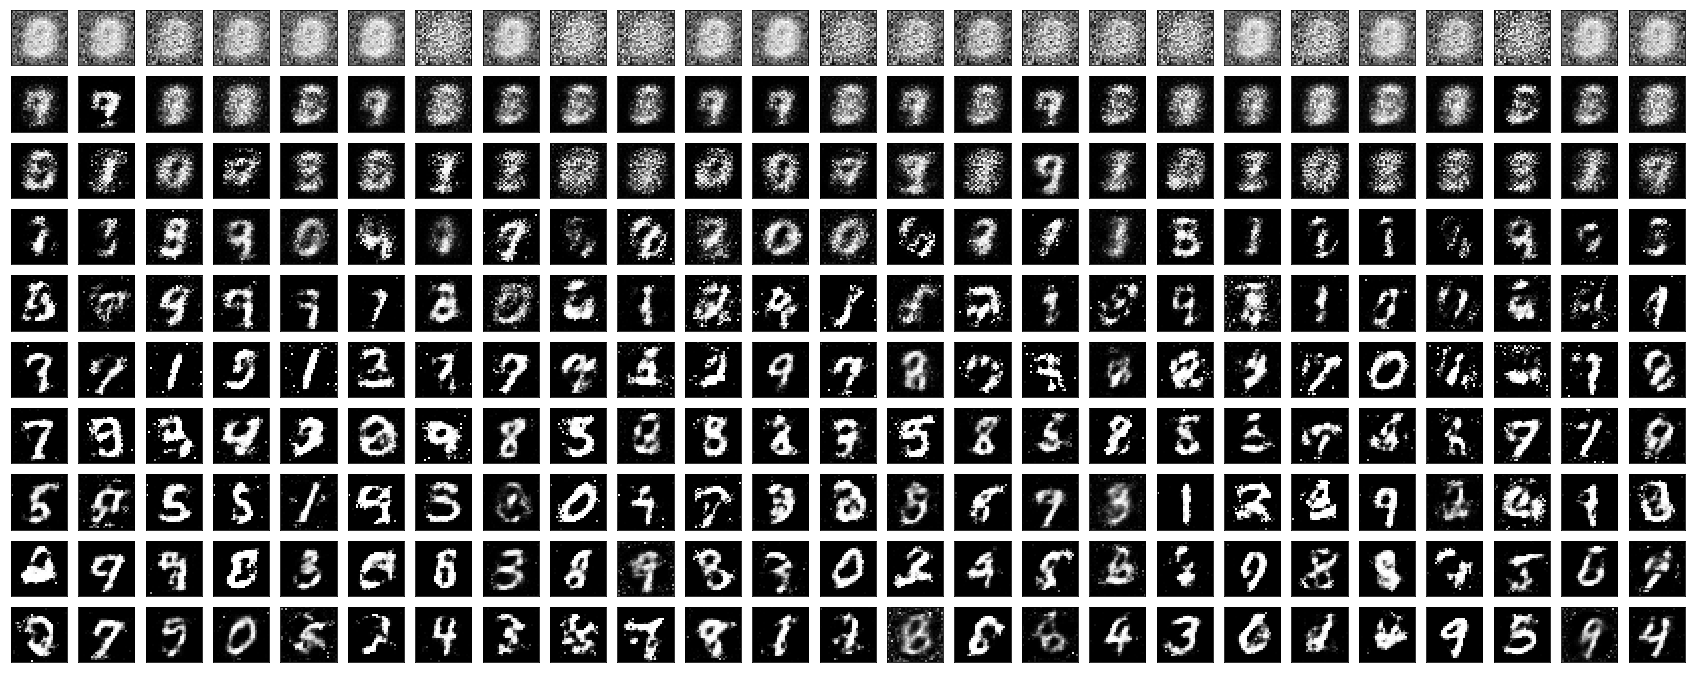

In [18]:
# 指定要查看的轮次
epoch_idx = [0, 5, 10, 20, 40, 60, 80, 100, 150, 250] # 一共300轮，不要越界
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### 生成新的图片

In [19]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1, 1, size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                           feed_dict={noise_img: sample_noise})

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


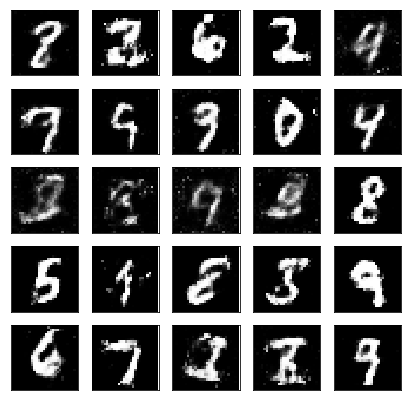

In [20]:
_ = view_samples(0, [gen_samples])

# DCGAN生成手写数字

该代码将在之前GAN生成MNIST数据的基础上进行改进，对generator改为transposed convolution结构，对discriminator采用卷积结构，提高模型生成效果。

## 导入数据

继续用前面导入的mnist数据

## 构建模型

- inputs
- generator
- discriminator
- loss
- optimizer

### Inputs

In [21]:
def get_inputs(noise_dim, image_height, image_width, image_depth):
    """
    :param noise_dim: 噪声图片的size
    :param image_height: 真实图像的height
    :param image_width: 真实图像的width
    :param image_depth: 真实图像的depth
    """ 
    inputs_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_depth], name='inputs_real')
    inputs_noise = tf.placeholder(tf.float32, [None, noise_dim], name='inputs_noise')
    
    return inputs_real, inputs_noise

### Generator

In [22]:
def get_generator(noise_img, output_dim, is_train=True, alpha=0.01):
    """
    :param noise_img: 噪声信号，tensor类型
    :param output_dim: 生成图片的depth
    :param is_train: 是否为训练状态，该参数主要用于作为batch_normalization方法中的参数使用
    :param alpha: Leaky ReLU系数
    """
    
    with tf.variable_scope("generator", reuse=(not is_train)):
        # 100 x 1 to 4 x 4 x 512
        # 全连接层
        layer1 = tf.layers.dense(noise_img, 4*4*512)
        layer1 = tf.reshape(layer1, [-1, 4, 4, 512])
        # batch normalization
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        # Leaky ReLU
        layer1 = tf.maximum(alpha * layer1, layer1)
        # dropout
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        # 4 x 4 x 512 to 7 x 7 x 256
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 4, strides=1, padding='valid')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        # 7 x 7 256 to 14 x 14 x 128
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        # 14 x 14 x 128 to 28 x 28 x 1
        logits = tf.layers.conv2d_transpose(layer3, output_dim, 3, strides=2, padding='same')
        # MNIST原始数据集的像素范围在0-1，这里的生成图片范围为(-1,1)
        # 因此在训练时，记住要把MNIST像素范围进行resize
        outputs = tf.tanh(logits)
        
        return outputs

### Discriminator

In [23]:
def get_discriminator(inputs_img, reuse=False, alpha=0.01):
    """
    @param inputs_img: 输入图片，tensor类型
    @param alpha: Leaky ReLU系数
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # 28 x 28 x 1 to 14 x 14 x 128
        # 第一层不加入BN
        layer1 = tf.layers.conv2d(inputs_img, 128, 3, strides=2, padding='same')
        layer1 = tf.maximum(alpha * layer1, layer1)
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        # 14 x 14 x 128 to 7 x 7 x 256
        layer2 = tf.layers.conv2d(layer1, 256, 3, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        # 7 x 7 x 256 to 4 x 4 x 512
        layer3 = tf.layers.conv2d(layer2, 512, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        # 4 x 4 x 512 to 4*4*512 x 1
        flatten = tf.reshape(layer3, (-1, 4*4*512))
        logits = tf.layers.dense(flatten, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

### Loss

In [24]:
def get_loss(inputs_real, inputs_noise, image_depth, smooth=0.1):
    """
    @param inputs_real: 输入图片，tensor类型
    @param inputs_noise: 噪声图片，tensor类型
    @param image_depth: 图片的depth（或者叫channel）
    @param smooth: label smoothing的参数
    """
    
    g_outputs = get_generator(inputs_noise, image_depth, is_train=True)
    d_logits_real, d_outputs_real = get_discriminator(inputs_real)
    d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, reuse=True)
    
    # 计算Loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_outputs_fake)*(1-smooth)))
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_outputs_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_outputs_fake)))
    d_loss = tf.add(d_loss_real, d_loss_fake)
    
    return g_loss, d_loss

### Optimizer

In [25]:
def get_optimizer(g_loss, d_loss, beta1=0.4, learning_rate=0.001):
    """
    @param g_loss: Generator的Loss
    @param d_loss: Discriminator的Loss
    @learning_rate: 学习率
    """
    
    train_vars = tf.trainable_variables()
    
    g_vars = [var for var in train_vars if var.name.startswith("generator")]
    d_vars = [var for var in train_vars if var.name.startswith("discriminator")]
    
    # Optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return g_opt, d_opt

###### 辅助函数，用来在迭代中显示图片

In [26]:
def plot_images(samples):
    fig, axes = plt.subplots(nrows=1, ncols=25, sharex=True, sharey=True, figsize=(50,2))
    for img, ax in zip(samples, axes):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0)

In [27]:
def show_generator_output(sess, n_images, inputs_noise, output_dim):
    """
    @param sess: TensorFlow session
    @param n_images: 展示图片的数量
    @param inputs_noise: 噪声图片
    @param output_dim: 图片的depth（或者叫channel）
    @param image_mode: 图像模式：RGB或者灰度
    """
    cmap = 'Greys_r'
    noise_shape = inputs_noise.get_shape().as_list()[-1]
    # 生成噪声图片
    examples_noise = np.random.uniform(-1, 1, size=[n_images, noise_shape])

    samples = sess.run(get_generator(inputs_noise, output_dim, False),
                       feed_dict={inputs_noise: examples_noise})

    
    result = np.squeeze(samples, -1)
    return result

## 训练

In [28]:
# 定义参数
batch_size = 64
noise_size = 100
epochs = 5
n_samples = 25
learning_rate = 0.001
beta1 = 0.4

def train(noise_size, data_shape, batch_size, n_samples):
    """
    @param noise_size: 噪声size
    @param data_shape: 真实图像shape
    @batch_size:
    @n_samples: 显示示例图片数量
    """
    
    # 存储loss
    losses = []
    steps = 0
    
    inputs_real, inputs_noise = get_inputs(noise_size, data_shape[1], data_shape[2], data_shape[3])
    g_loss, d_loss = get_loss(inputs_real, inputs_noise, data_shape[-1])
    g_train_opt, d_train_opt = get_optimizer(g_loss, d_loss, beta1, learning_rate)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # 迭代epoch
        for e in range(epochs):
            for batch_i in range(mnist.train.num_examples//batch_size):
                steps += 1
                batch = mnist.train.next_batch(batch_size)

                batch_images = batch[0].reshape((batch_size, data_shape[1], data_shape[2], data_shape[3]))
                # scale to -1, 1
                batch_images = batch_images * 2 - 1

                # noise
                batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))

                # run optimizer
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_noise: batch_noise})
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_noise: batch_noise})
                
                if steps % 101 == 0:
                    train_loss_d = d_loss.eval({inputs_real: batch_images,
                                                inputs_noise: batch_noise})
                    train_loss_g = g_loss.eval({inputs_real: batch_images,
                                                inputs_noise: batch_noise})
                    losses.append((train_loss_d, train_loss_g))
                    # 显示图片
                    samples = show_generator_output(sess, n_samples, inputs_noise, data_shape[-1])
                    plot_images(samples)
                    print("Epoch {}/{}....".format(e+1, epochs), 
                          "Discriminator Loss: {:.4f}....".format(train_loss_d),
                          "Generator Loss: {:.4f}....". format(train_loss_g))


Epoch 1/5.... Discriminator Loss: 0.8498.... Generator Loss: 5.5176....
Epoch 1/5.... Discriminator Loss: 0.8170.... Generator Loss: 2.3477....
Epoch 1/5.... Discriminator Loss: 1.2260.... Generator Loss: 0.8070....
Epoch 1/5.... Discriminator Loss: 1.1756.... Generator Loss: 0.7062....
Epoch 1/5.... Discriminator Loss: 1.1067.... Generator Loss: 1.8102....
Epoch 1/5.... Discriminator Loss: 1.0079.... Generator Loss: 1.1817....
Epoch 1/5.... Discriminator Loss: 0.8604.... Generator Loss: 1.4592....
Epoch 1/5.... Discriminator Loss: 1.1317.... Generator Loss: 2.5690....
Epoch 2/5.... Discriminator Loss: 0.9286.... Generator Loss: 1.8844....
Epoch 2/5.... Discriminator Loss: 0.8739.... Generator Loss: 1.4833....
Epoch 2/5.... Discriminator Loss: 0.9409.... Generator Loss: 0.8943....
Epoch 2/5.... Discriminator Loss: 0.7644.... Generator Loss: 1.4567....
Epoch 2/5.... Discriminator Loss: 1.1209.... Generator Loss: 2.2524....
Epoch 2/5.... Discriminator Loss: 0.9844.... Generator Loss: 0.9

/home/dlinking-lxy/more-space/pyworks/venv/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 3/5.... Discriminator Loss: 1.1530.... Generator Loss: 3.6433....
Epoch 3/5.... Discriminator Loss: 0.6981.... Generator Loss: 2.4228....
Epoch 3/5.... Discriminator Loss: 0.8870.... Generator Loss: 1.3235....
Epoch 3/5.... Discriminator Loss: 0.8230.... Generator Loss: 1.0872....
Epoch 3/5.... Discriminator Loss: 1.1268.... Generator Loss: 0.9697....
Epoch 4/5.... Discriminator Loss: 0.7476.... Generator Loss: 1.9160....
Epoch 4/5.... Discriminator Loss: 0.6680.... Generator Loss: 1.9881....
Epoch 4/5.... Discriminator Loss: 0.6874.... Generator Loss: 1.8619....
Epoch 4/5.... Discriminator Loss: 0.6592.... Generator Loss: 1.8390....
Epoch 4/5.... Discriminator Loss: 0.9296.... Generator Loss: 1.2033....
Epoch 4/5.... Discriminator Loss: 0.8620.... Generator Loss: 1.0597....
Epoch 4/5.... Discriminator Loss: 0.6119.... Generator Loss: 1.8615....
Epoch 4/5.... Discriminator Loss: 1.2093.... Generator Loss: 4.8881....
Epoch 4/5.... Discriminator Loss: 0.5933.... Generator Loss: 2.1

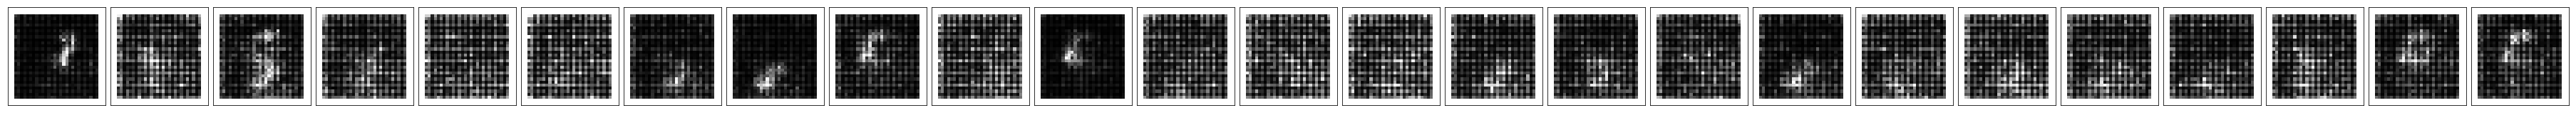

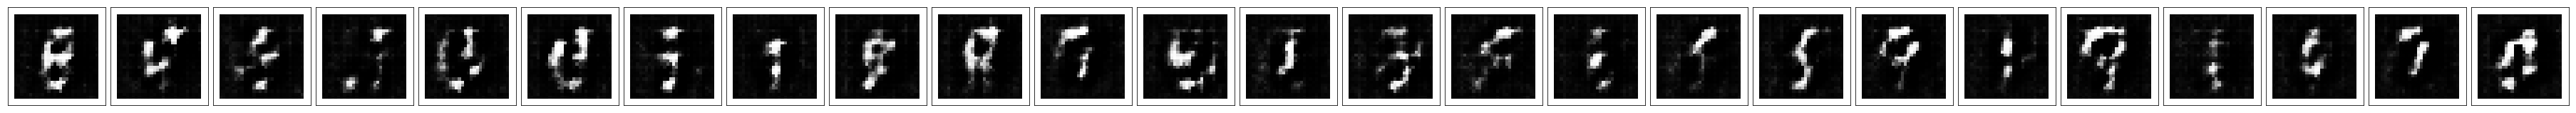

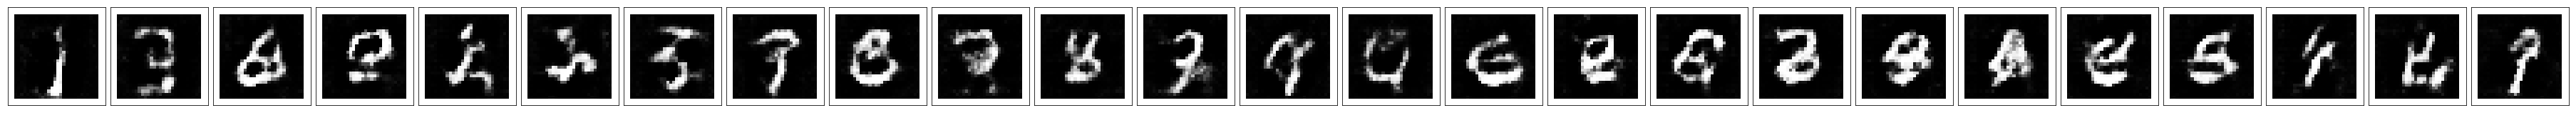

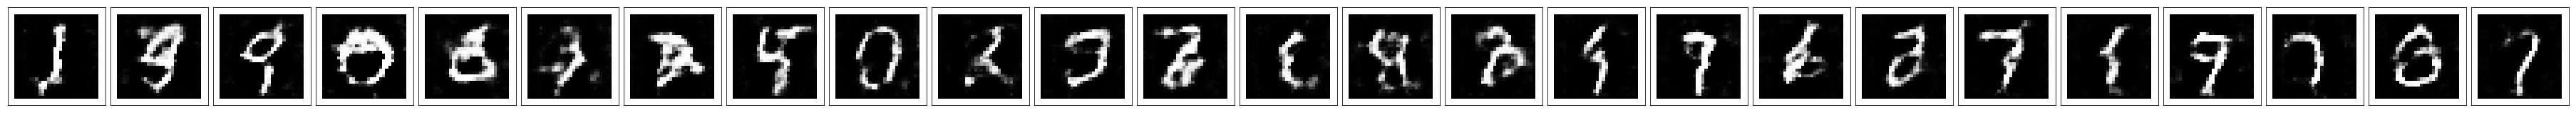

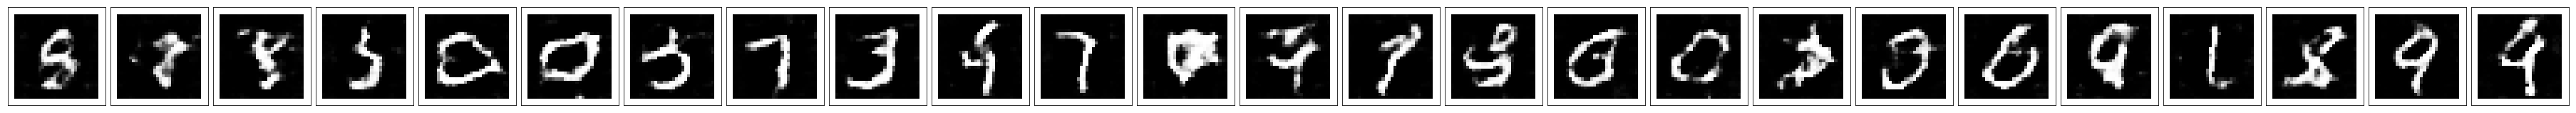

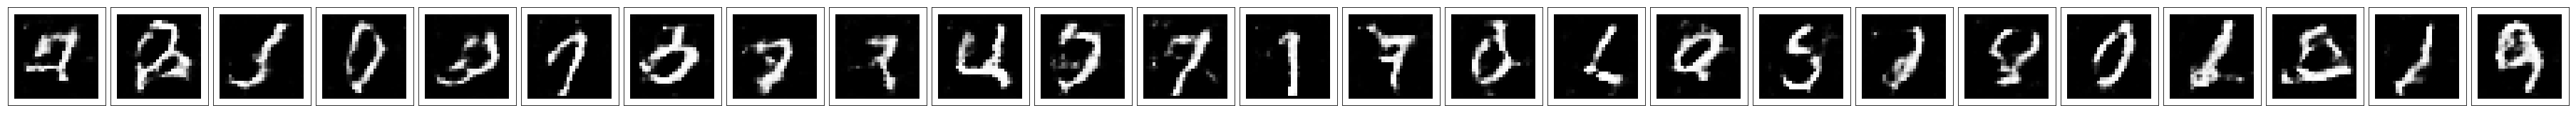

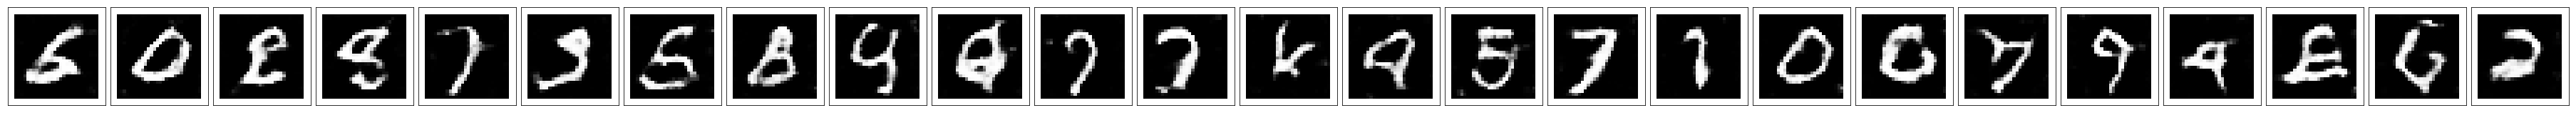

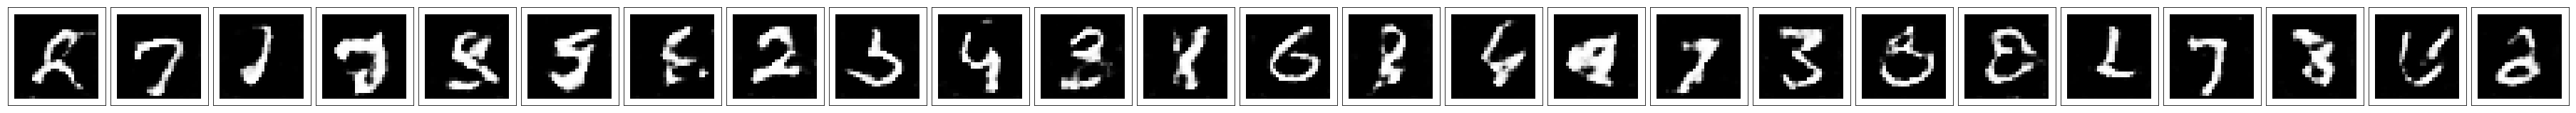

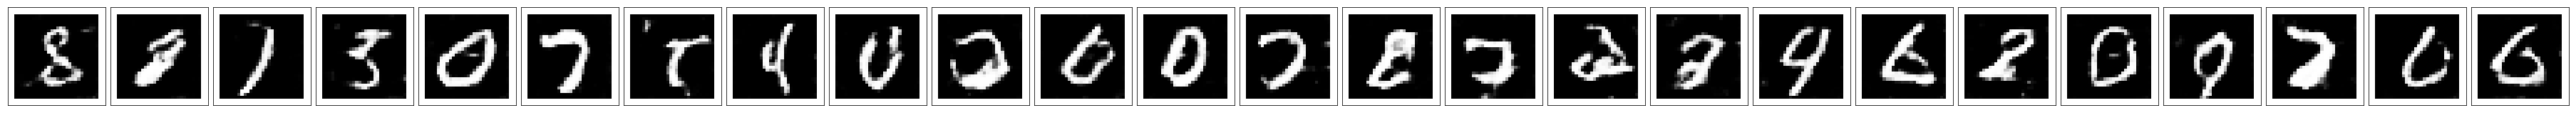

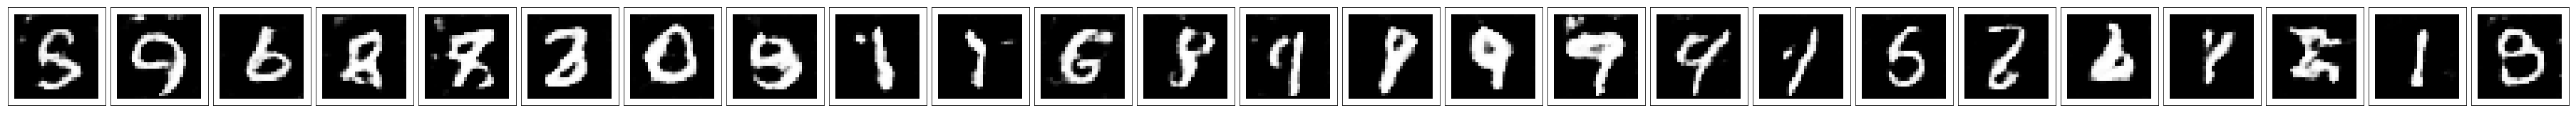

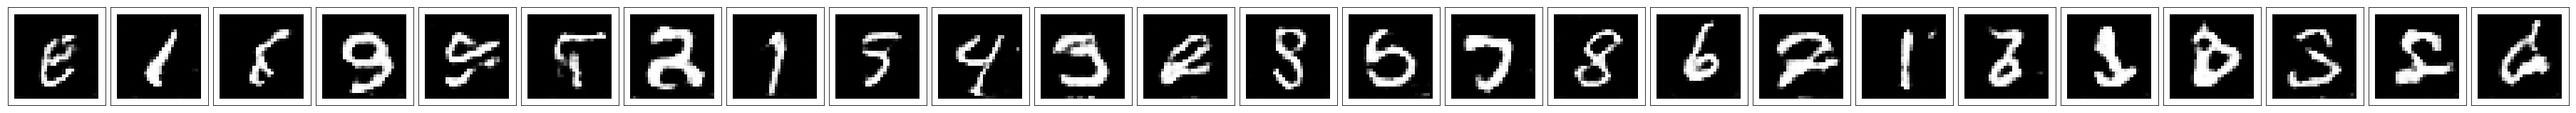

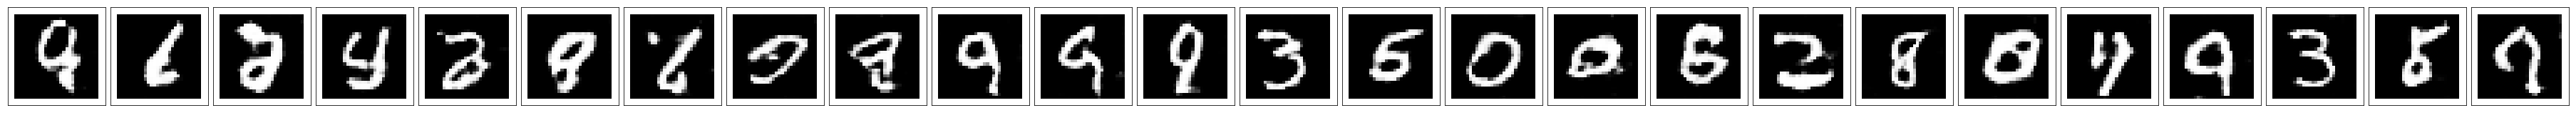

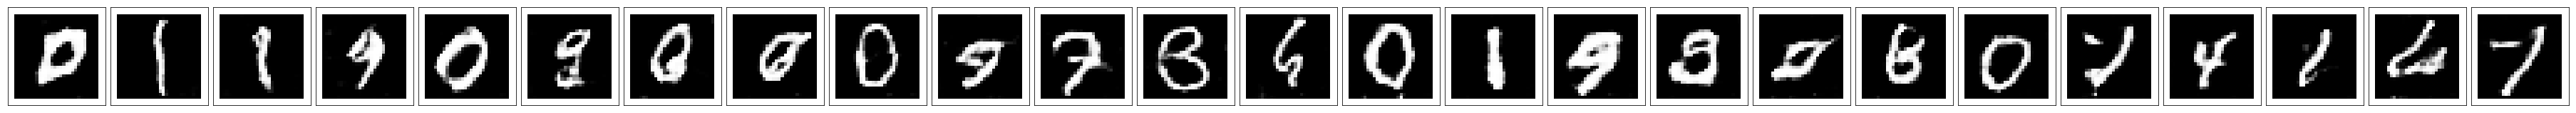

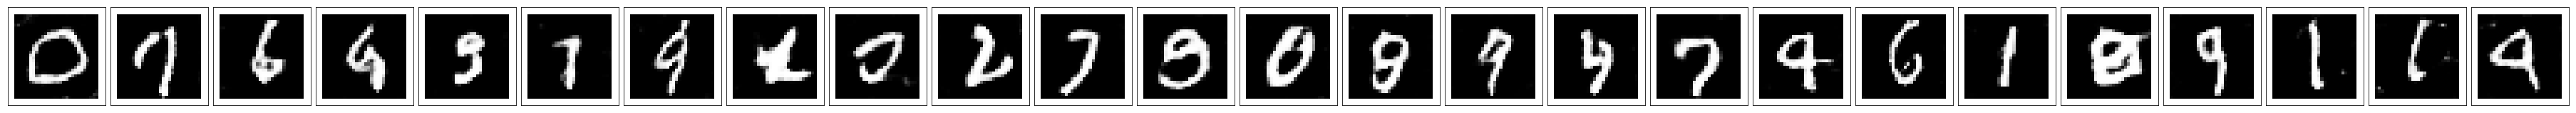

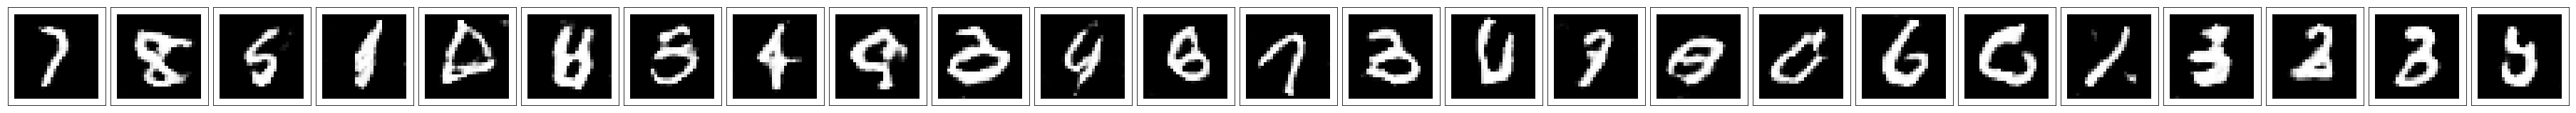

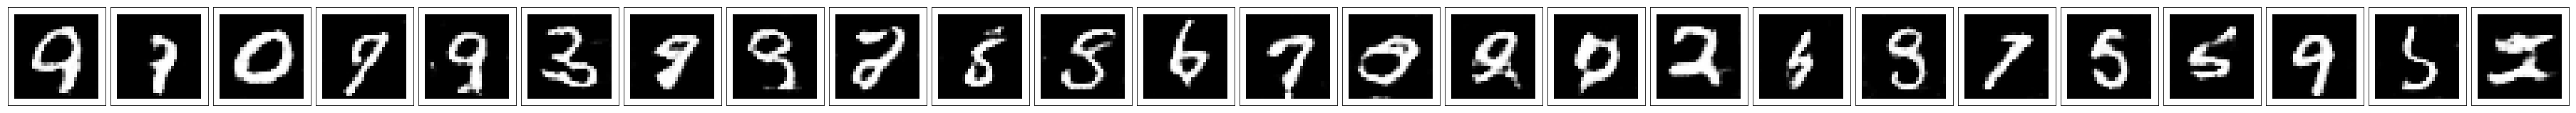

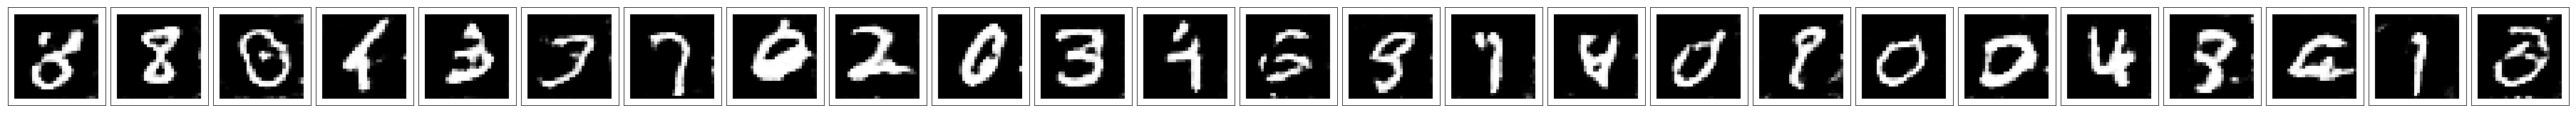

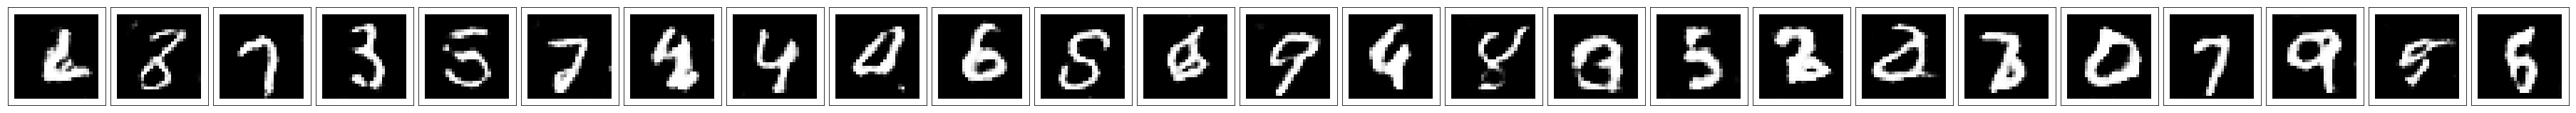

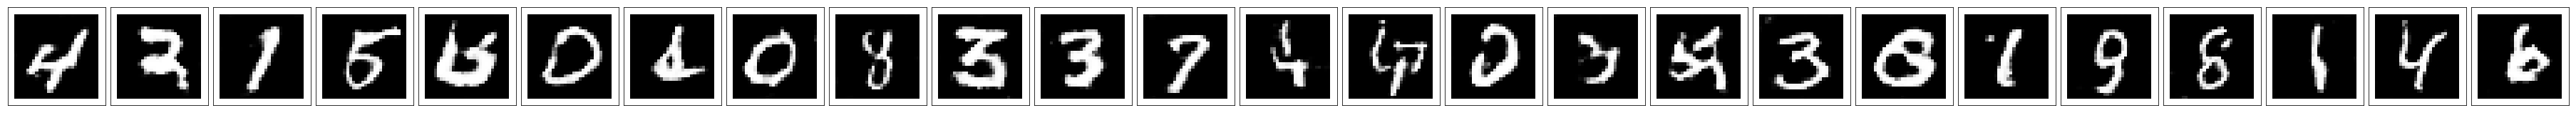

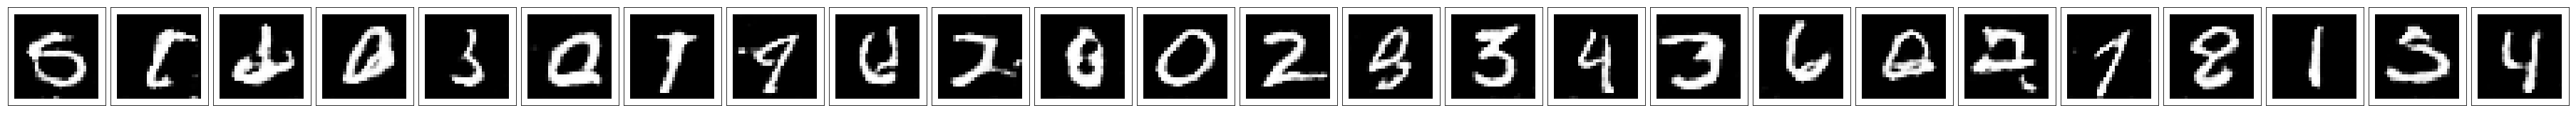

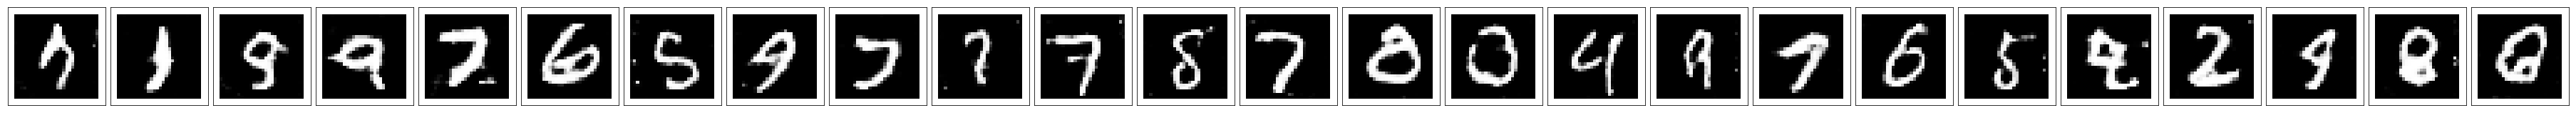

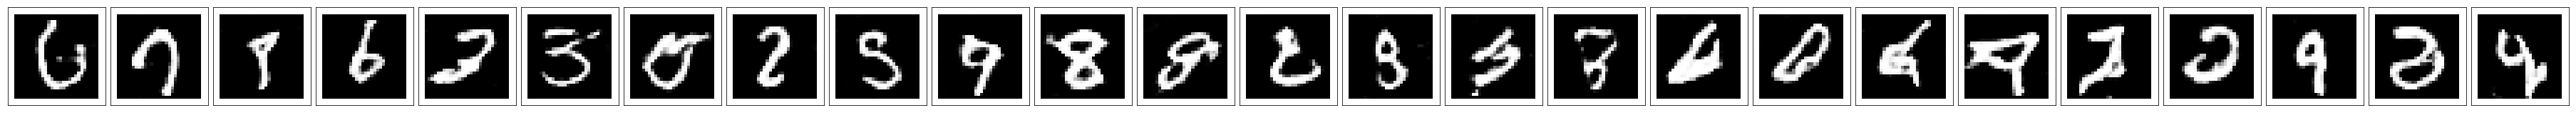

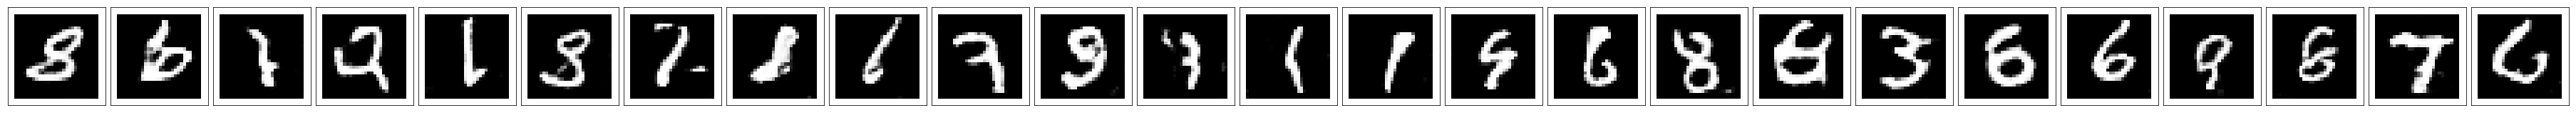

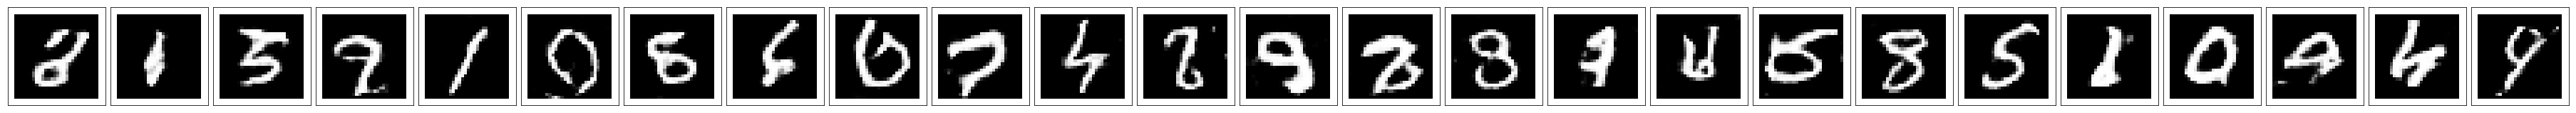

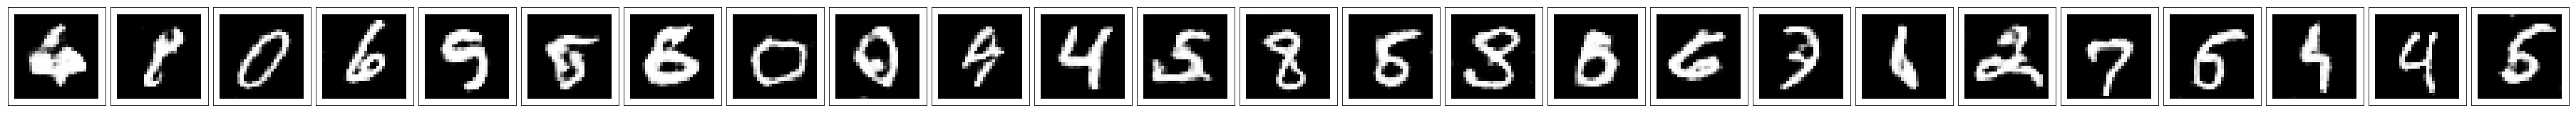

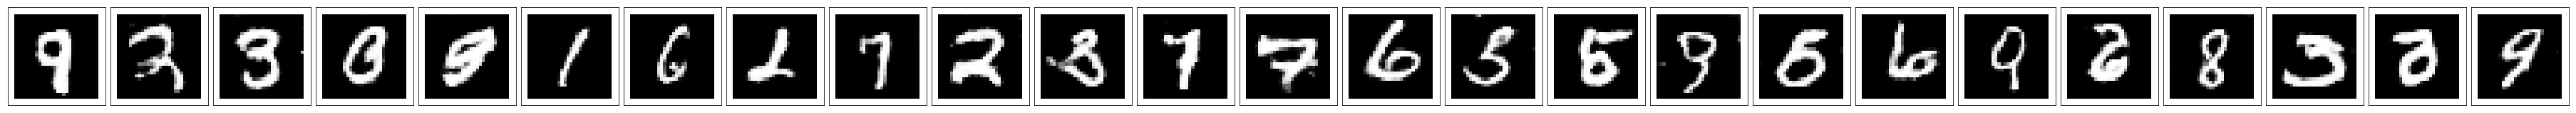

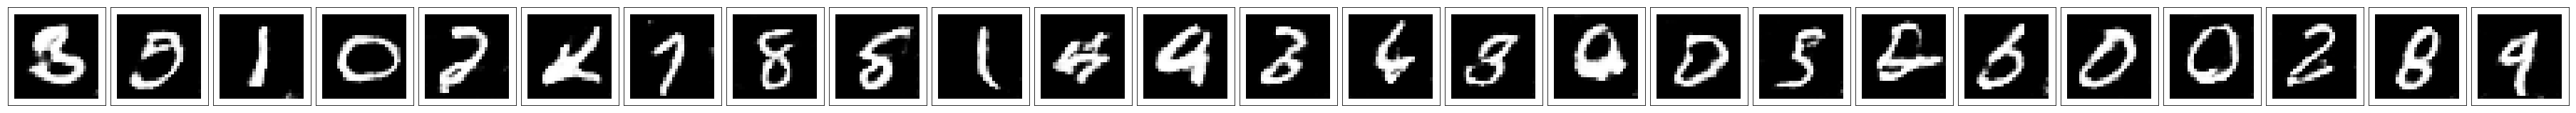

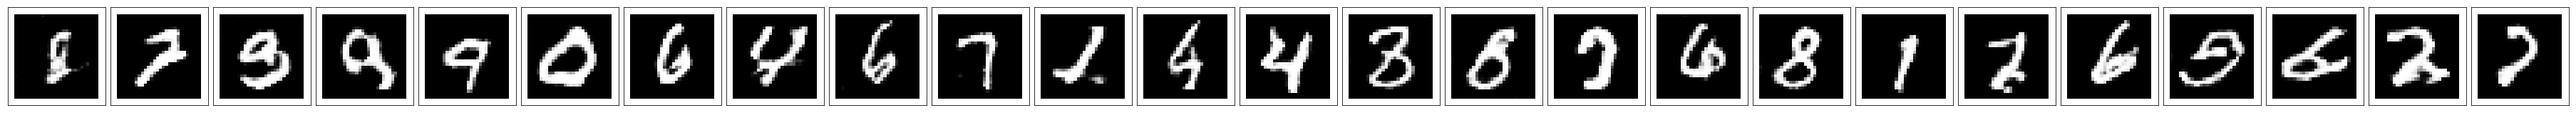

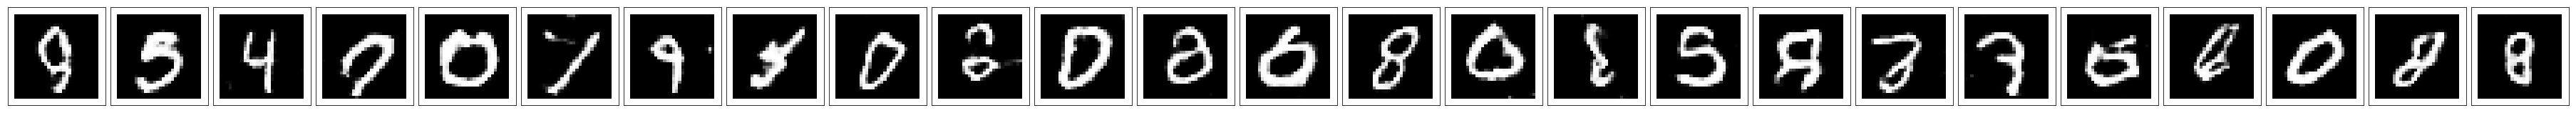

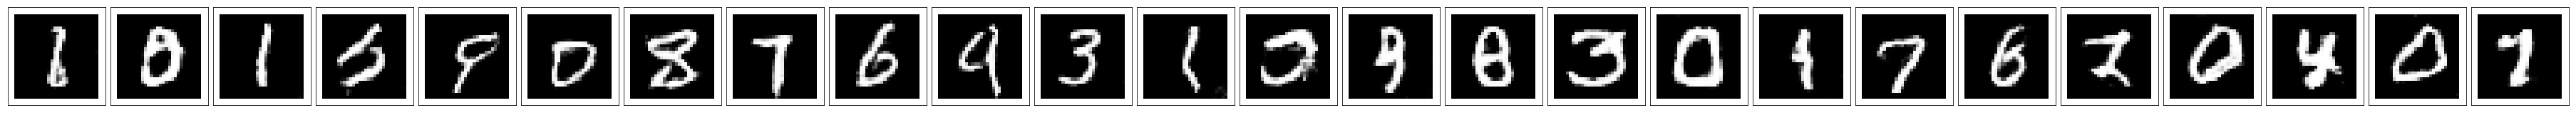

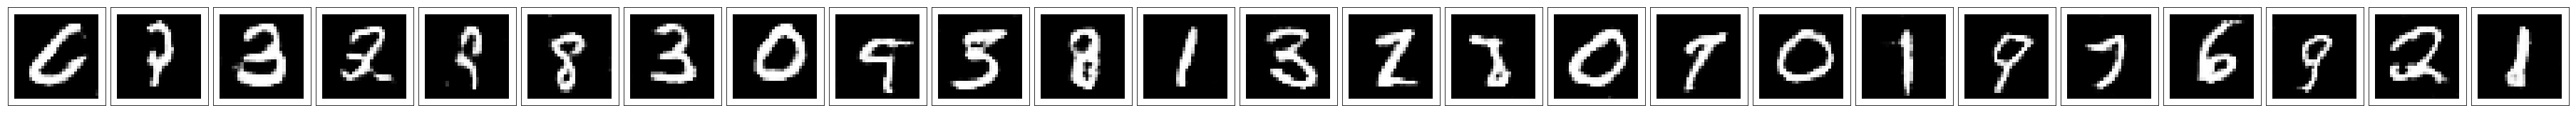

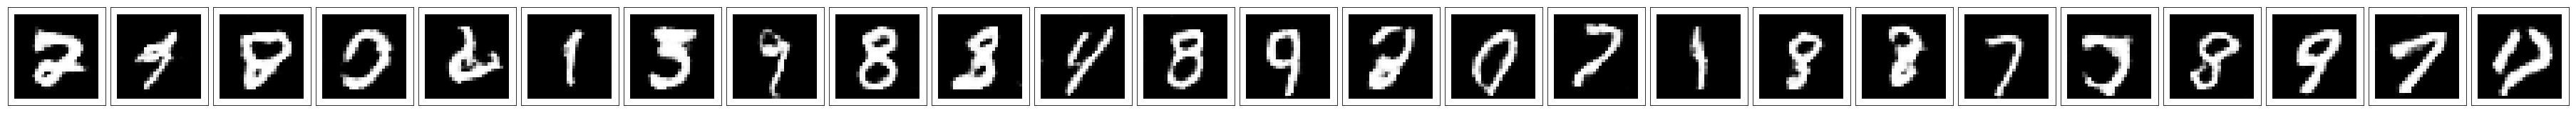

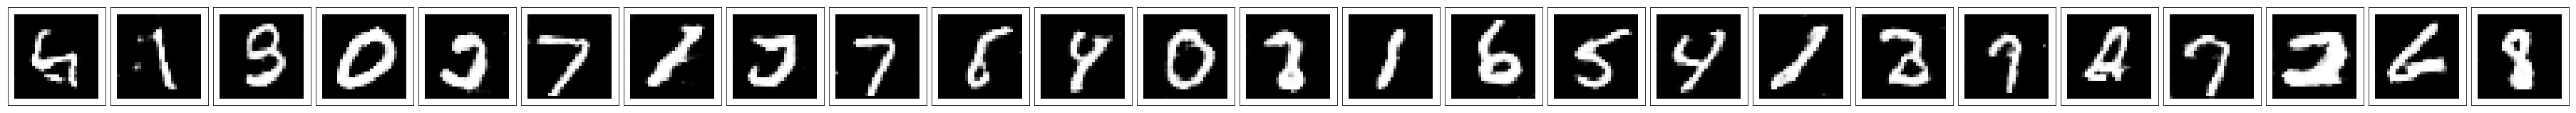

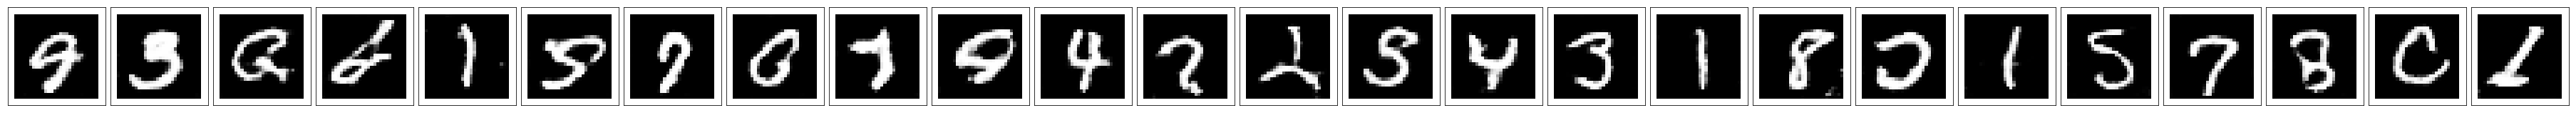

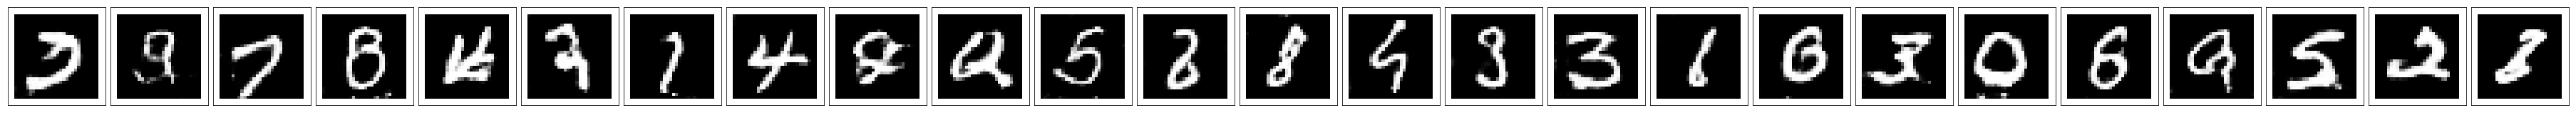

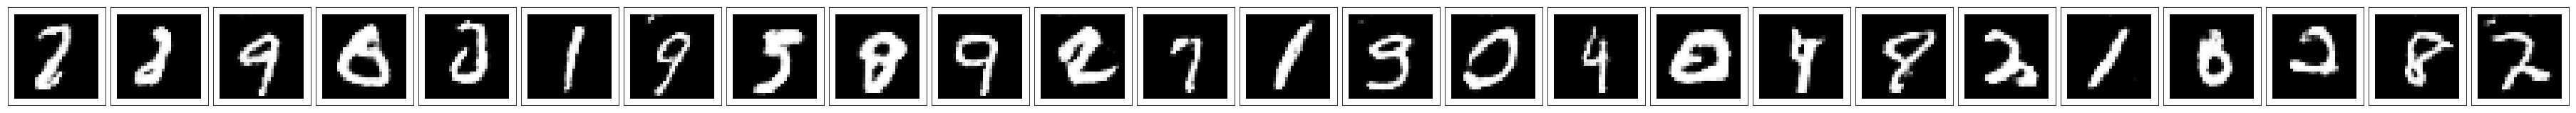

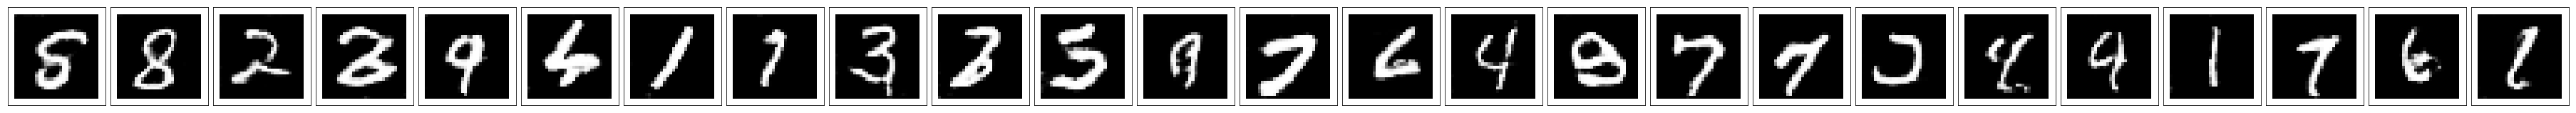

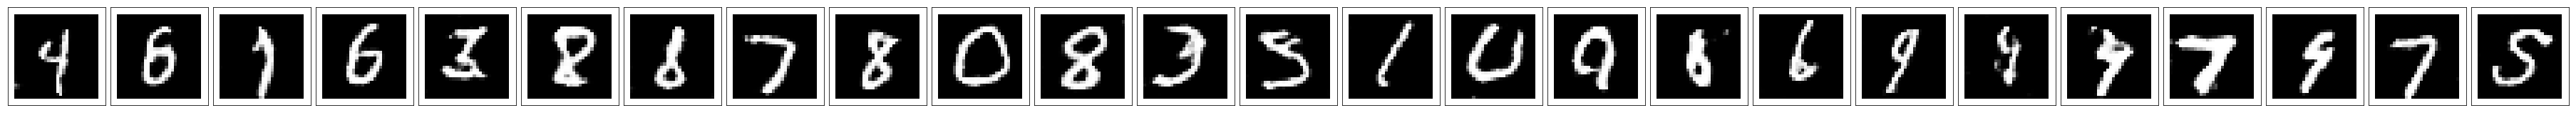

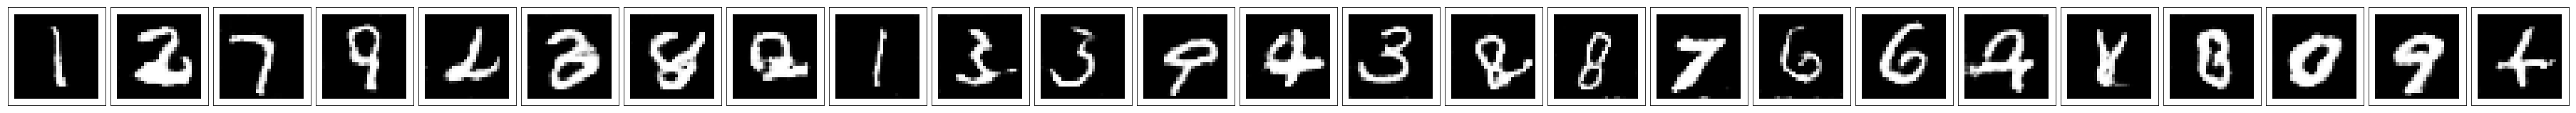

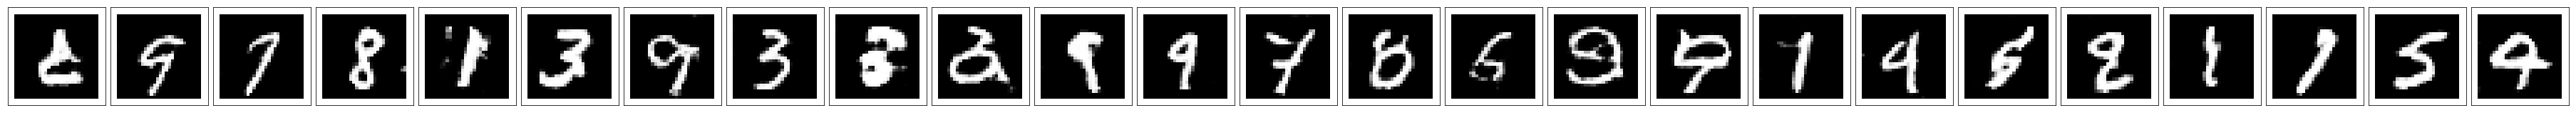

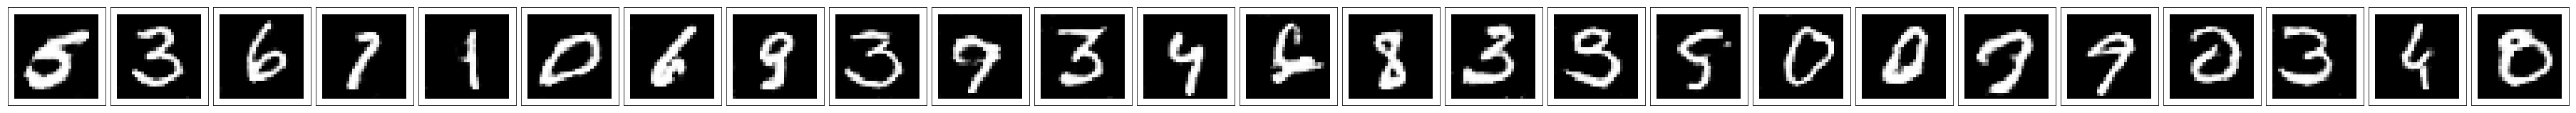

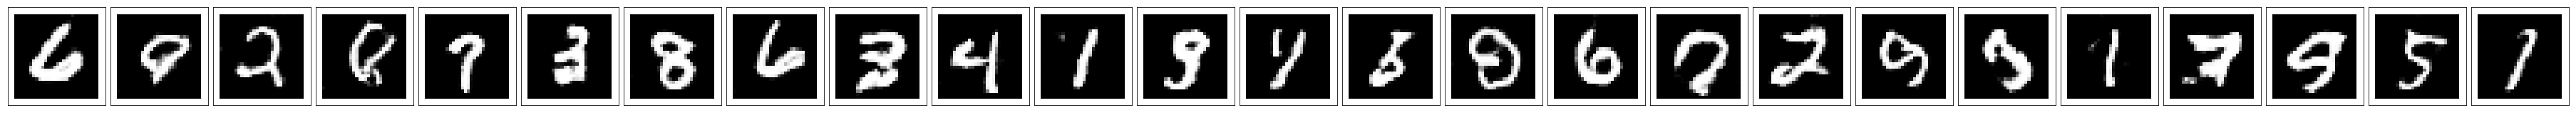

In [29]:
with tf.Graph().as_default():
    train(noise_size, [-1, 28, 28, 1], batch_size, n_samples)

# DCGAN生成马

该代码选取CIFAR图像中马的图像学习了一个深度卷积GAN模型，用来生成马的图像。

## 导入数据

http://www.cs.toronto.edu/~kriz/cifar.html

In [31]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tarfile


cifar10_path = 'cifar-10-batches-py'
tar_gz_path = './cifar-10-python.tar.gz'  # 大小163M
with tarfile.open(tar_gz_path) as tar:
    tar.extractall()
    tar.close()

    
# 加载数据
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    加载单批量的数据
    
    参数：
    cifar10_dataset_folder_path: 数据存储目录
    batch_id: 指定batch的编号
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    
    # features and labels
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

# 共有5个batch的训练数据
x_train, y_train = load_cfar10_batch(cifar10_path, 1)
for i in range(2, 6):
    features, labels = load_cfar10_batch(cifar10_path, i)
    x_train, y_train = np.concatenate([x_train, features]), np.concatenate([y_train, labels])

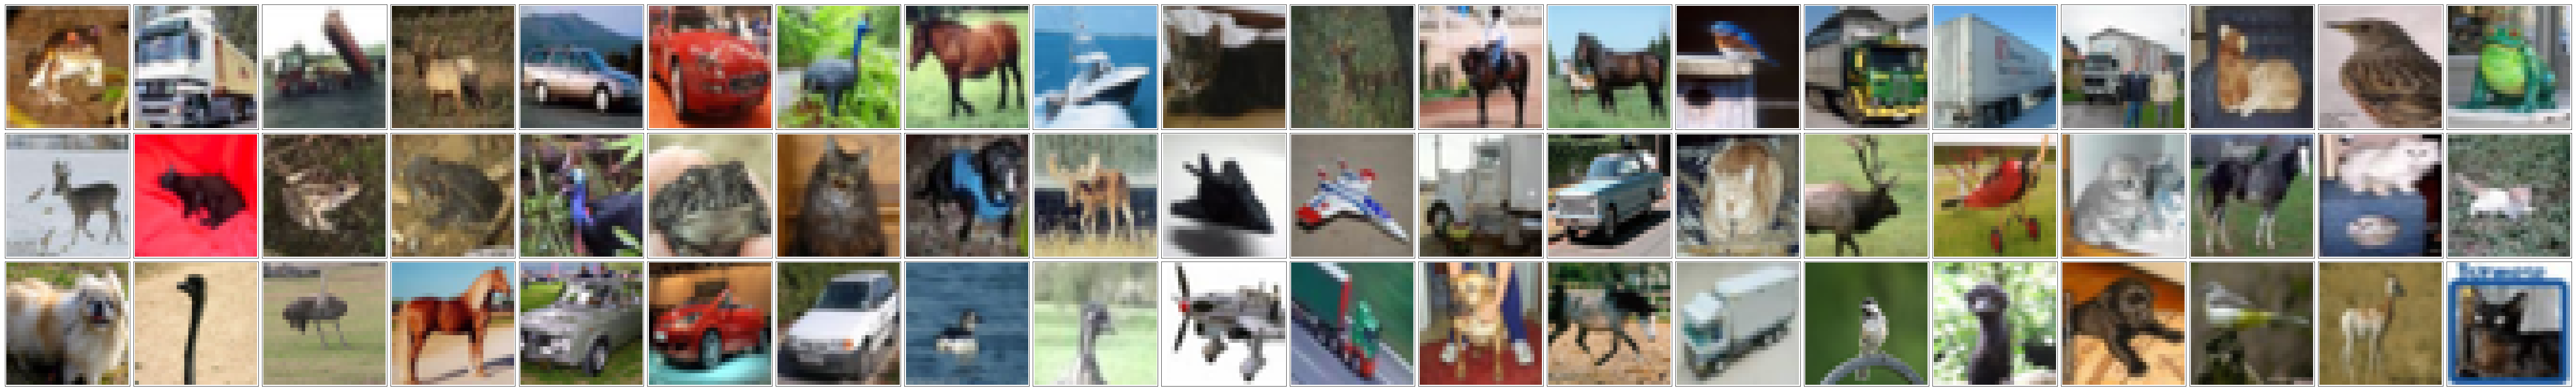

In [ ]:
# 显示图片
fig, axes = plt.subplots(nrows=3, ncols=20, sharex=True, sharey=True, figsize=(80,12))
imgs = x_train[:60]

for image, row in zip([imgs[:20], imgs[20:40], imgs[40:60]], axes):
    for img, ax in zip(image, row):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [ ]:
# 数据预处理，归一化
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

# 重塑
x_train_rows = x_train.reshape(x_train.shape[0], 32 * 32 * 3)

# 归一化
x_train = minmax.fit_transform(x_train_rows)

# 重新变为32 x 32 x 3
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)

# 选出马的图像
images = x_train[y_train==7]

## 构建模型

- inputs
- generator
- discriminator
- loss
- optimizer

### Inputs

In [ ]:
def get_inputs(noise_dim, image_height, image_width, image_depth):
    """
    :param noise_dim: 噪声图片的size
    :param image_height: 真实图像的height
    :param image_width: 真实图像的width
    :param image_depth: 真实图像的depth
    """ 
    inputs_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_depth], name='inputs_real')
    inputs_noise = tf.placeholder(tf.float32, [None, noise_dim], name='inputs_noise')
    
    return inputs_real, inputs_noise

### Generator

In [ ]:
def get_generator(noise_img, output_dim, is_train=True, alpha=0.01):
    """
    :param noise_img: 噪声信号，tensor类型
    :param output_dim: 生成图片的depth
    :param is_train: 是否为训练状态，该参数主要用于作为batch_normalization方法中的参数使用
    :param alpha: Leaky ReLU系数
    """
    
    with tf.variable_scope("generator", reuse=(not is_train)):
        # 100 x 1 to 4 x 4 x 512
        # 全连接层
        layer1 = tf.layers.dense(noise_img, 4*4*512)
        layer1 = tf.reshape(layer1, [-1, 4, 4, 512])
        # batch normalization
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        # Leaky ReLU
        layer1 = tf.maximum(alpha * layer1, layer1)
        # dropout
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        # 4 x 4 x 512 to 8 x 8 x 256
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 4, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        # 8 x 8 256 to 16 x 16 x 128
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        # 16 x 16 x 128 to 32 x 32 x 3
        logits = tf.layers.conv2d_transpose(layer3, output_dim, 3, strides=2, padding='same')
        # MNIST原始数据集的像素范围在0-1，这里的生成图片范围为(-1,1)
        # 因此在训练时，记住要把MNIST像素范围进行resize
        outputs = tf.tanh(logits)
        
        return outputs

### Discriminator

In [ ]:
def get_discriminator(inputs_img, reuse=False, alpha=0.01):
    """
    @param inputs_img: 输入图片，tensor类型
    @param alpha: Leaky ReLU系数
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # 32 x 32 x 3 to 16 x 16 x 128
        # 第一层不加入BN
        layer1 = tf.layers.conv2d(inputs_img, 128, 3, strides=2, padding='same')
        layer1 = tf.maximum(alpha * layer1, layer1)
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        # 16 x 16 x 128 to 8 x 8 x 256
        layer2 = tf.layers.conv2d(layer1, 256, 3, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        # 8 x 8 x 256 to 4 x 4 x 512
        layer3 = tf.layers.conv2d(layer2, 512, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        # 4 x 4 x 512 to 4*4*512 x 1
        flatten = tf.reshape(layer3, (-1, 4*4*512))
        logits = tf.layers.dense(flatten, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

### Loss

In [ ]:
def get_loss(inputs_real, inputs_noise, image_depth, smooth=0.1):
    """
    @param inputs_real: 输入图片，tensor类型
    @param inputs_noise: 噪声图片，tensor类型
    @param image_depth: 图片的depth（或者叫channel）
    @param smooth: label smoothing的参数
    """
    
    g_outputs = get_generator(inputs_noise, image_depth, is_train=True)
    d_logits_real, d_outputs_real = get_discriminator(inputs_real)
    d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, reuse=True)
    
    # 计算Loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_outputs_fake)*(1-smooth)))
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_outputs_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_outputs_fake)))
    d_loss = tf.add(d_loss_real, d_loss_fake)
    
    return g_loss, d_loss

### Optimizer

In [ ]:
def get_optimizer(g_loss, d_loss, beta1=0.4, learning_rate=0.001):
    """
    @param g_loss: Generator的Loss
    @param d_loss: Discriminator的Loss
    @learning_rate: 学习率
    """
    
    train_vars = tf.trainable_variables()
    
    g_vars = [var for var in train_vars if var.name.startswith("generator")]
    d_vars = [var for var in train_vars if var.name.startswith("discriminator")]
    
    # Optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return g_opt, d_opt

######  辅助函数，用来在迭代中显示图片

In [ ]:
def plot_images(samples):
    samples = (samples + 1) / 2
    fig, axes = plt.subplots(nrows=1, ncols=15, sharex=True, sharey=True, figsize=(30,2))
    for img, ax in zip(samples, axes):
        ax.imshow(img.reshape((32, 32, 3)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0)

In [ ]:
def show_generator_output(sess, n_images, inputs_noise, output_dim):
    """
    @param sess: TensorFlow session
    @param n_images: 展示图片的数量
    @param inputs_noise: 噪声图片
    @param output_dim: 图片的depth（或者叫channel）
    @param image_mode: 图像模式：RGB或者灰度
    """
    cmap = 'Greys_r'
    noise_shape = inputs_noise.get_shape().as_list()[-1]
    # 生成噪声图片
    examples_noise = np.random.uniform(-1, 1, size=[n_images, noise_shape])

    samples = sess.run(get_generator(inputs_noise, output_dim, False),
                       feed_dict={inputs_noise: examples_noise})
    return samples

## 训练

In [ ]:
# 定义参数
batch_size = 64
noise_size = 100
epochs = 50
n_samples = 15
learning_rate = 0.001
beta1 = 0.4

def train(noise_size, data_shape, batch_size, n_samples):
    """
    @param noise_size: 噪声size
    @param data_shape: 真实图像shape
    @batch_size:
    @n_samples: 显示示例图片数量
    """
    
    # 存储loss
    losses = []
    steps = 0
    
    inputs_real, inputs_noise = get_inputs(noise_size, data_shape[1], data_shape[2], data_shape[3])
    g_loss, d_loss = get_loss(inputs_real, inputs_noise, data_shape[-1])
    g_train_opt, d_train_opt = get_optimizer(g_loss, d_loss, beta1, learning_rate)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # 迭代epoch
        for e in range(epochs):
            for batch_i in range(images.shape[0]//batch_size-1):
                steps += 1
                batch_images = images[batch_i * batch_size: (batch_i+1)*batch_size]

                # scale to -1, 1
                batch_images = batch_images * 2 - 1

                # noise
                batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))

                # run optimizer
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_noise: batch_noise})
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_noise: batch_noise})
                
                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({inputs_real: batch_images,
                                                inputs_noise: batch_noise})
                    train_loss_g = g_loss.eval({inputs_real: batch_images,
                                                inputs_noise: batch_noise})
                    losses.append((train_loss_d, train_loss_g))
                    # 显示图片
                    samples = show_generator_output(sess, n_samples, inputs_noise, data_shape[-1])
                    plot_images(samples)
                    print("Epoch {}/{}....".format(e+1, epochs), 
                          "Discriminator Loss: {:.4f}....".format(train_loss_d),
                          "Generator Loss: {:.4f}....". format(train_loss_g))


Epoch 2/50.... Discriminator Loss: 1.5843.... Generator Loss: 5.6757....
Epoch 3/50.... Discriminator Loss: 0.4660.... Generator Loss: 2.6225....
Epoch 4/50.... Discriminator Loss: 0.8898.... Generator Loss: 1.8236....
Epoch 6/50.... Discriminator Loss: 0.7798.... Generator Loss: 1.5123....
Epoch 7/50.... Discriminator Loss: 0.6154.... Generator Loss: 3.3120....
Epoch 8/50.... Discriminator Loss: 1.0622.... Generator Loss: 2.2784....
Epoch 10/50.... Discriminator Loss: 0.7057.... Generator Loss: 1.5264....
Epoch 11/50.... Discriminator Loss: 0.7541.... Generator Loss: 2.1220....
Epoch 12/50.... Discriminator Loss: 2.4946.... Generator Loss: 4.6505....
Epoch 13/50.... Discriminator Loss: 0.9695.... Generator Loss: 2.6547....
Epoch 15/50.... Discriminator Loss: 0.8020.... Generator Loss: 1.2126....
Epoch 16/50.... Discriminator Loss: 1.2413.... Generator Loss: 0.7053....
Epoch 17/50.... Discriminator Loss: 0.7134.... Generator Loss: 1.1999....
Epoch 19/50.... Discriminator Loss: 0.7893..

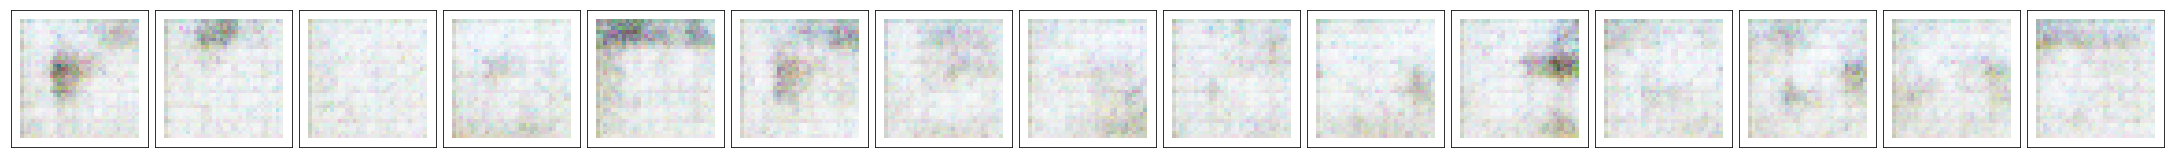

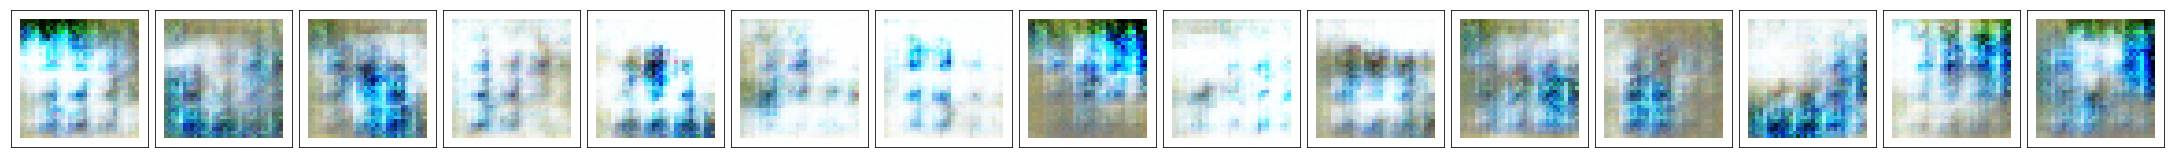

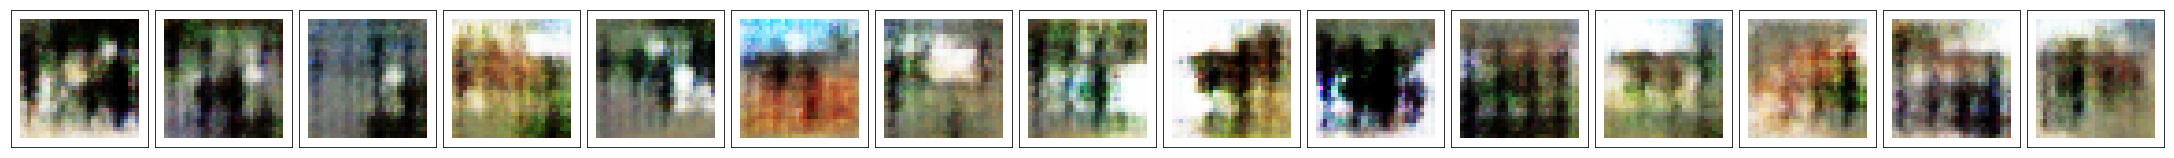

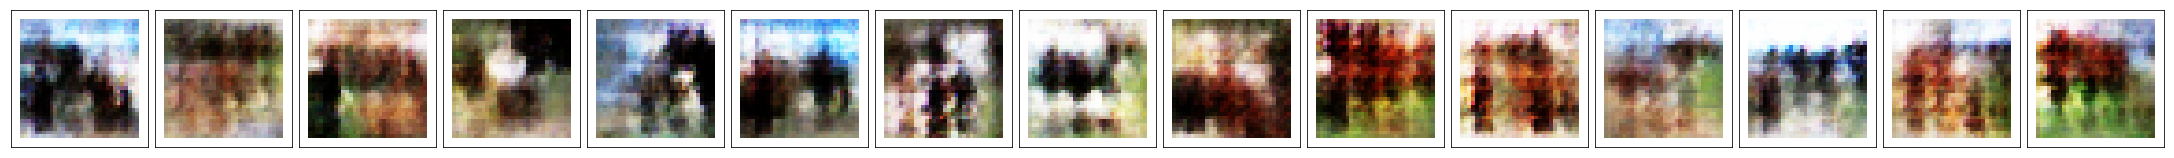

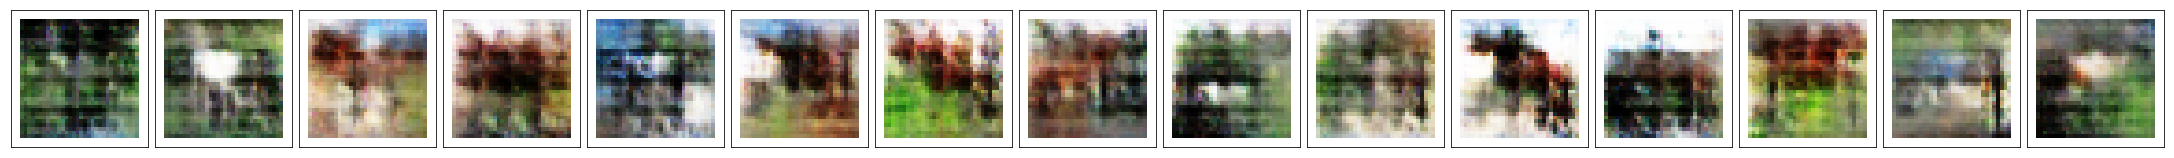

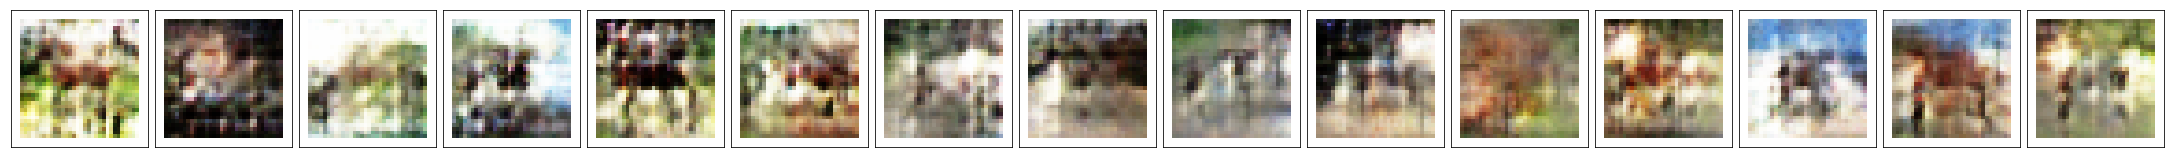

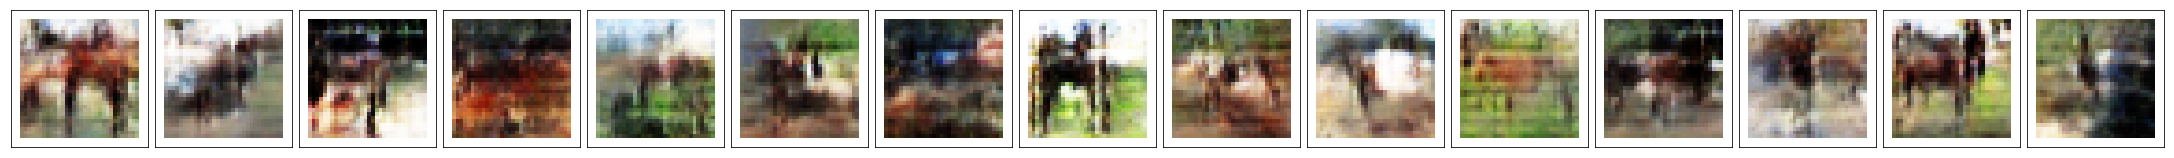

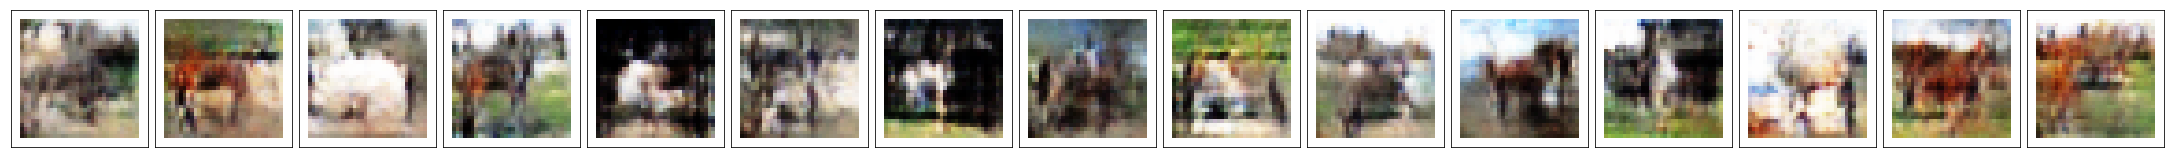

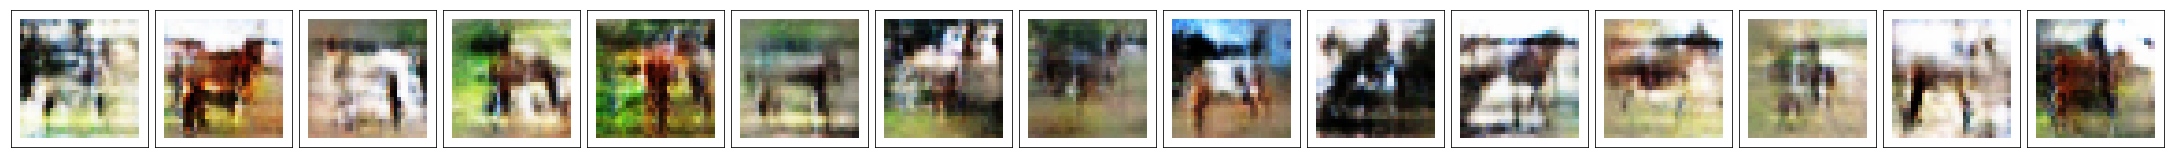

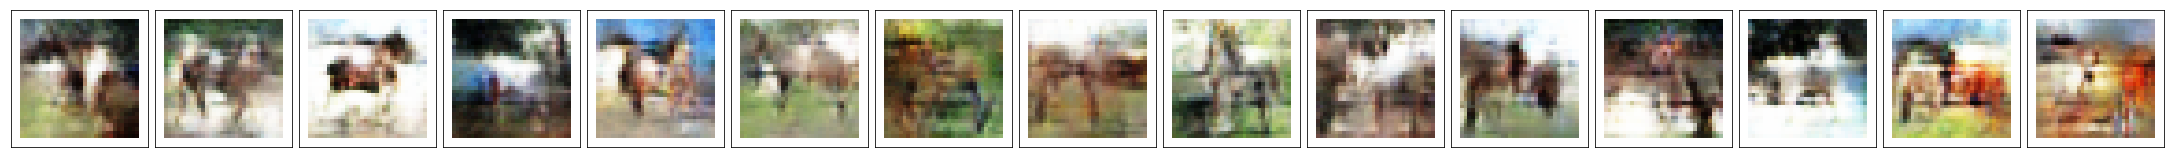

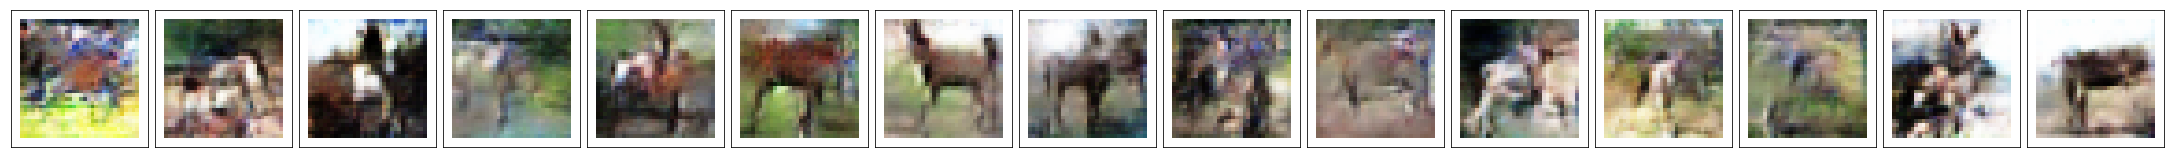

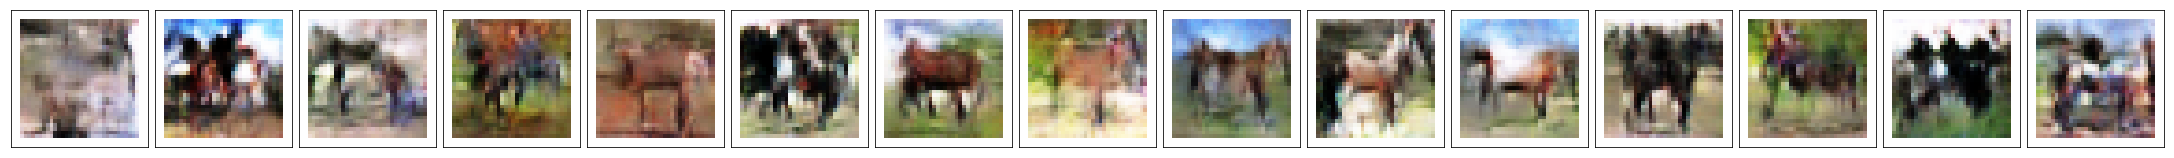

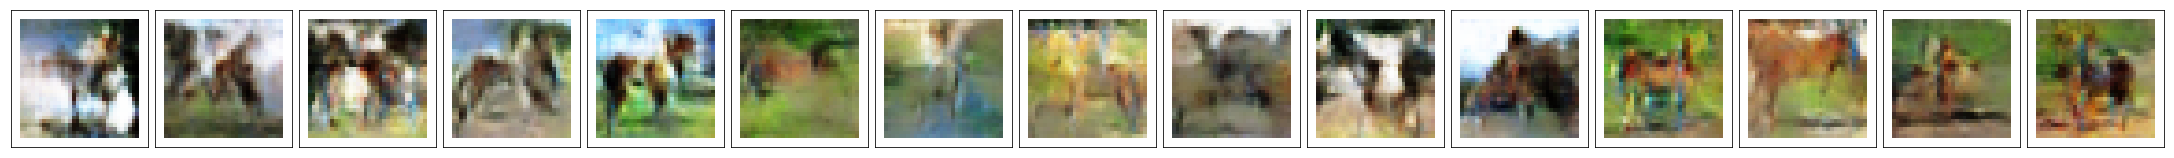

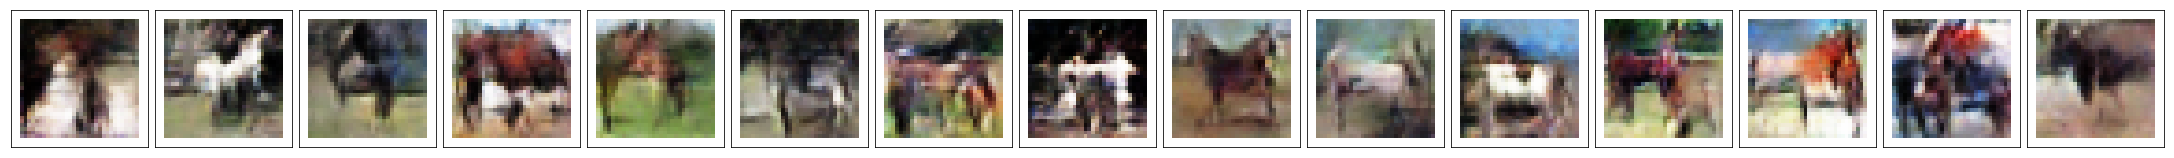

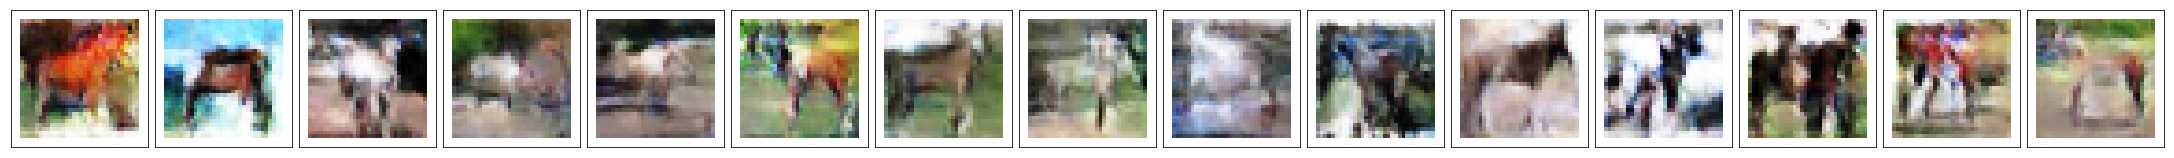

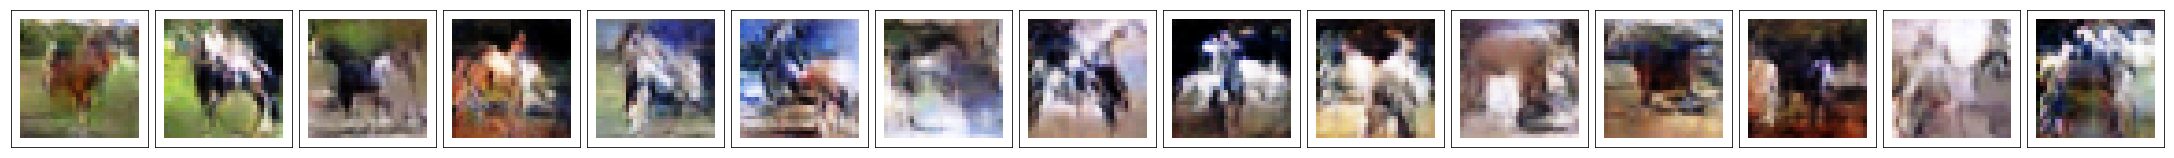

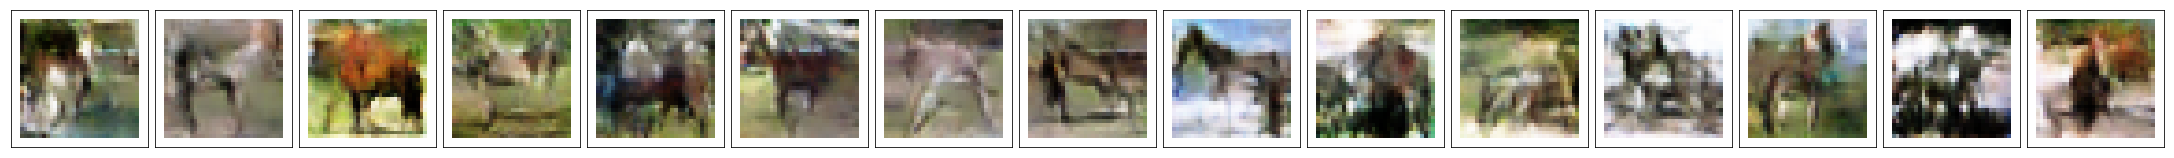

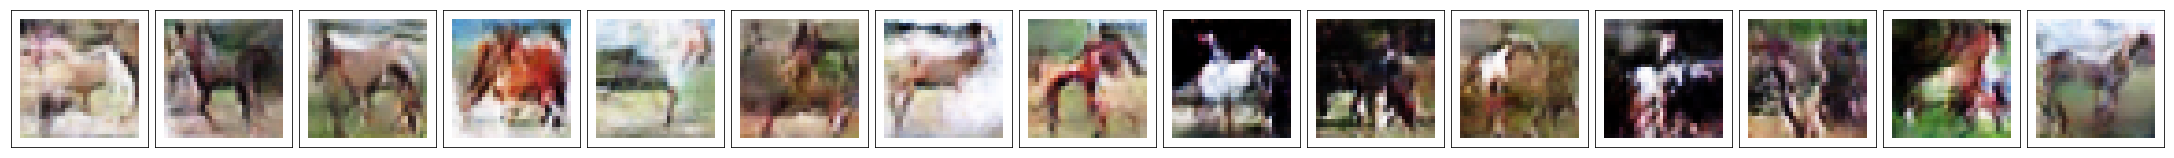

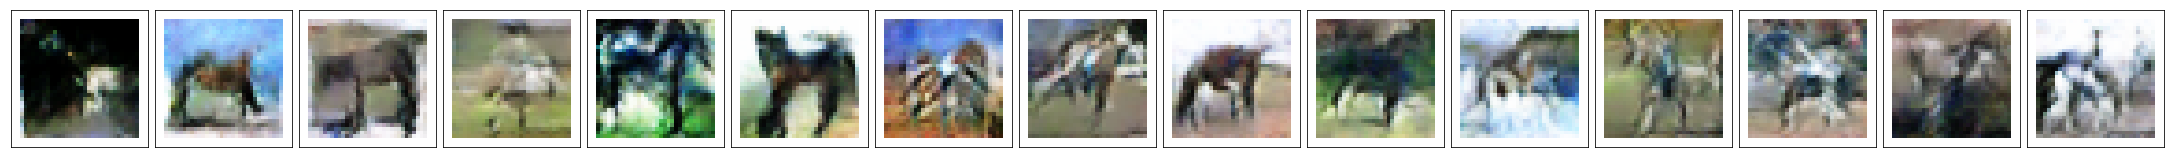

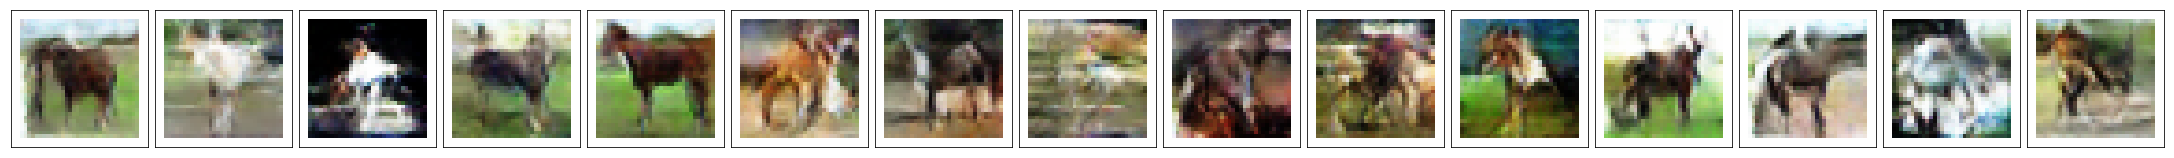

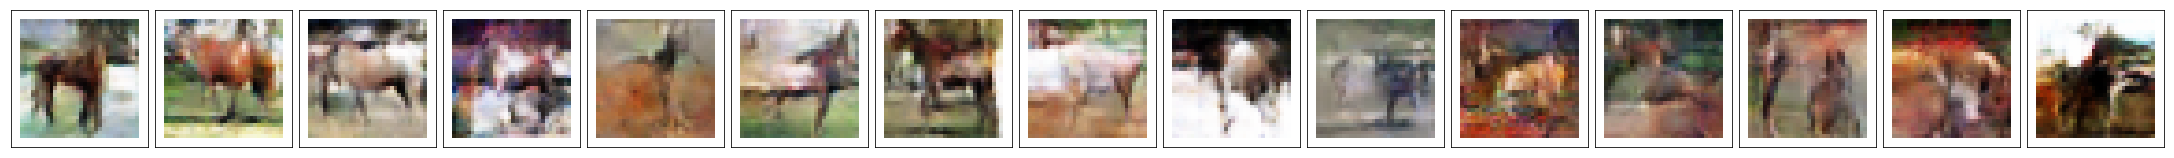

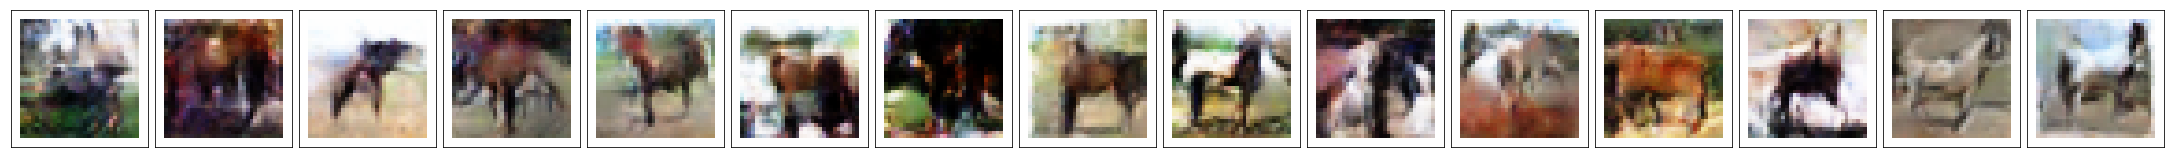

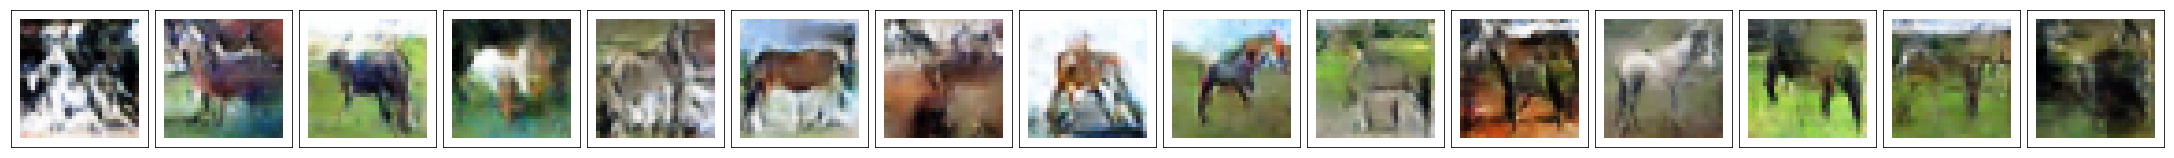

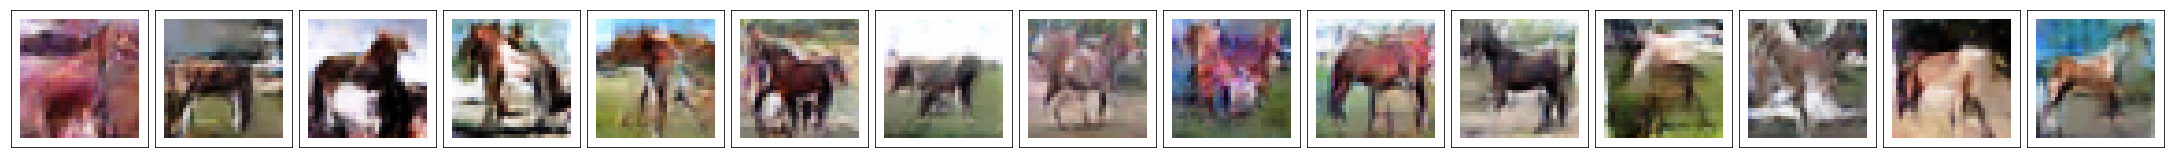

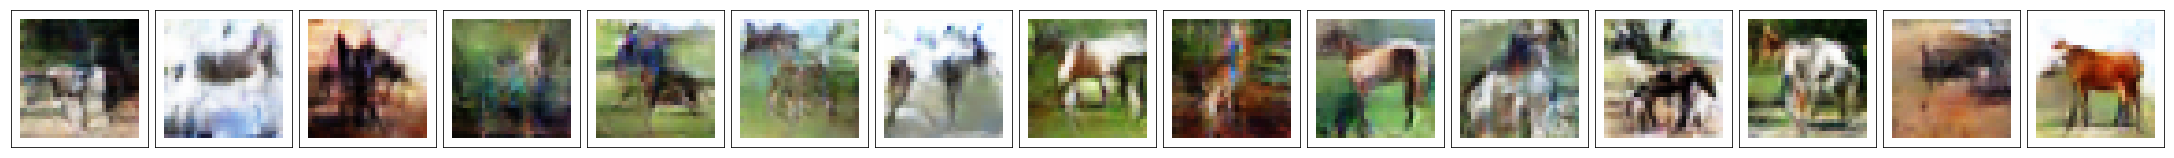

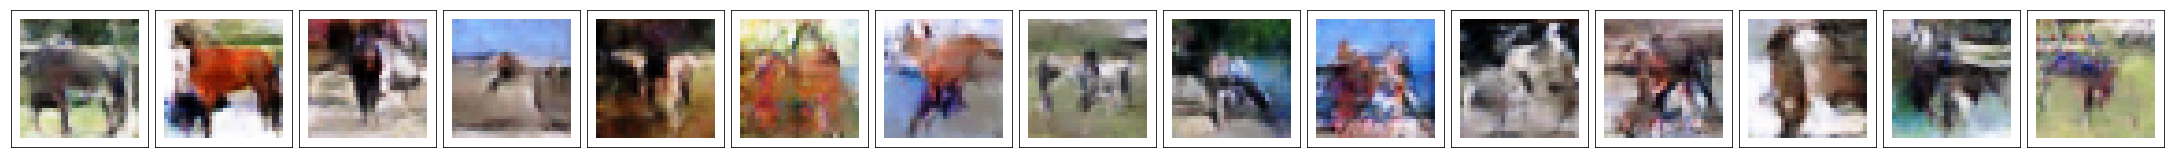

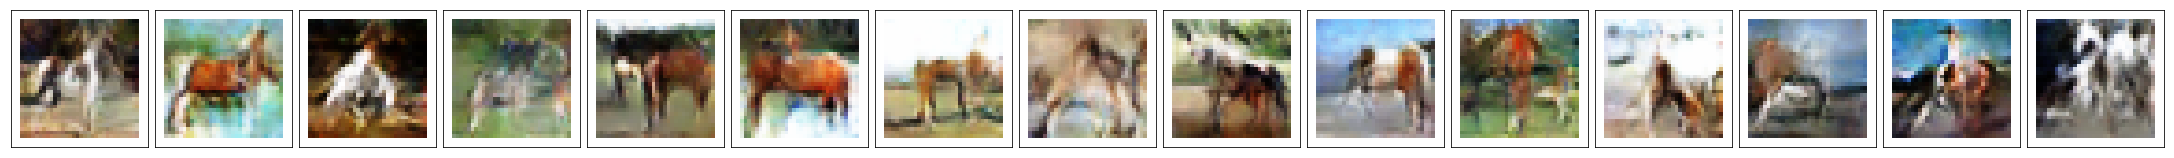

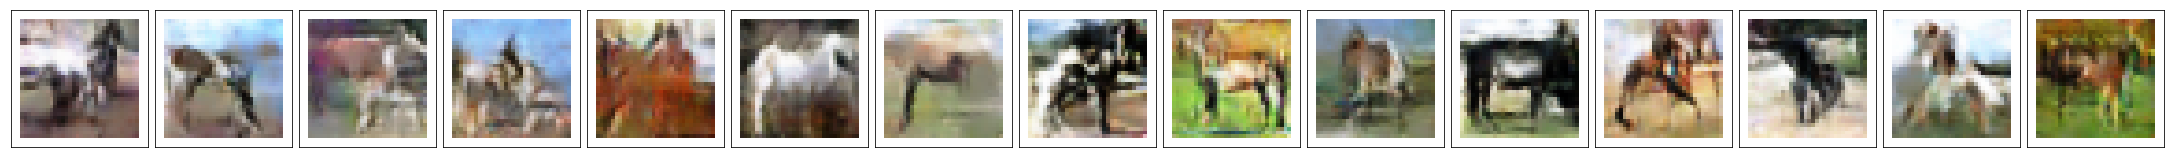

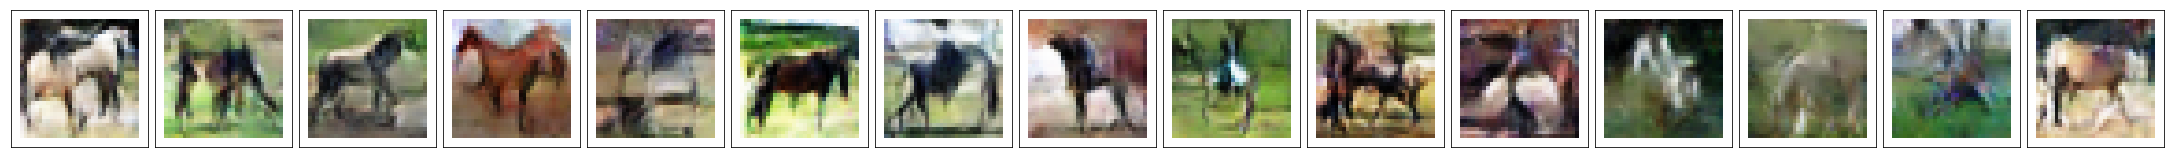

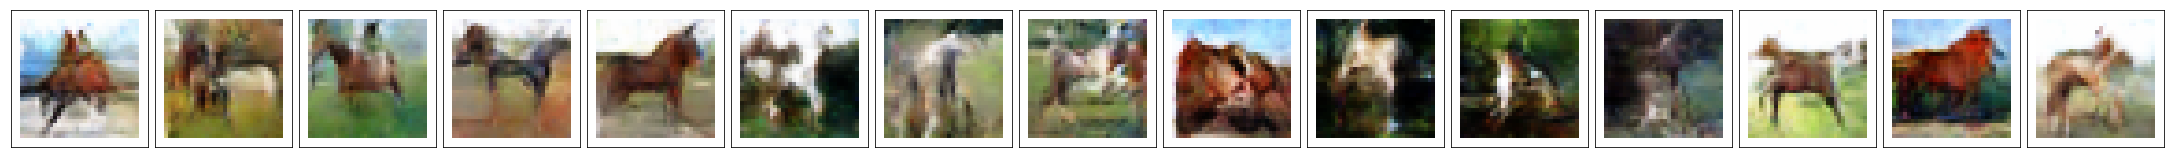

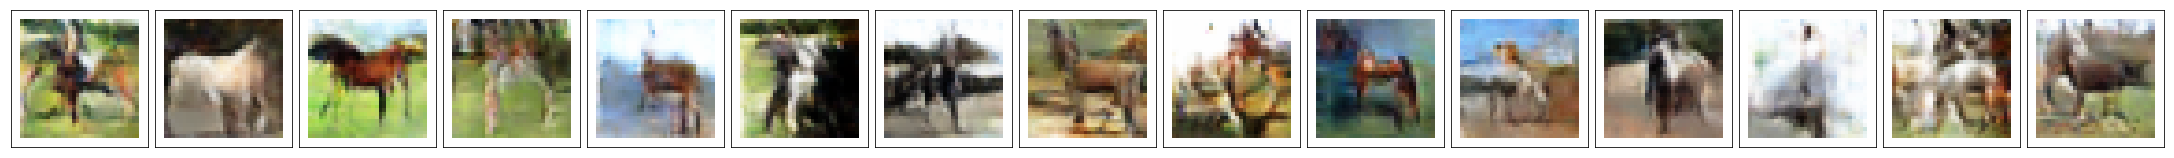

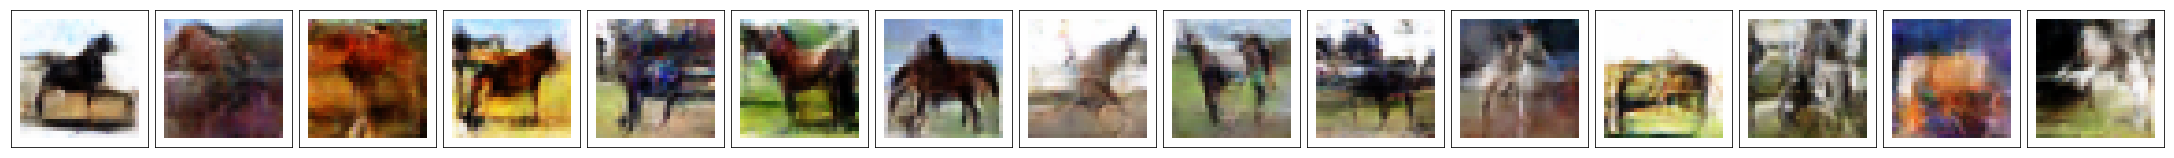

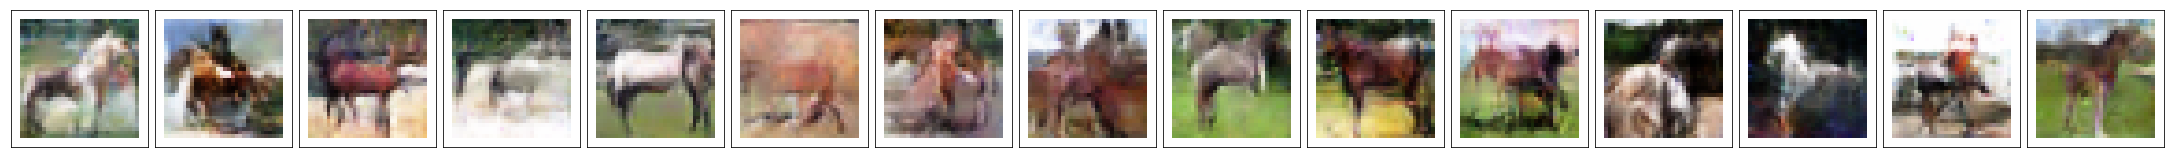

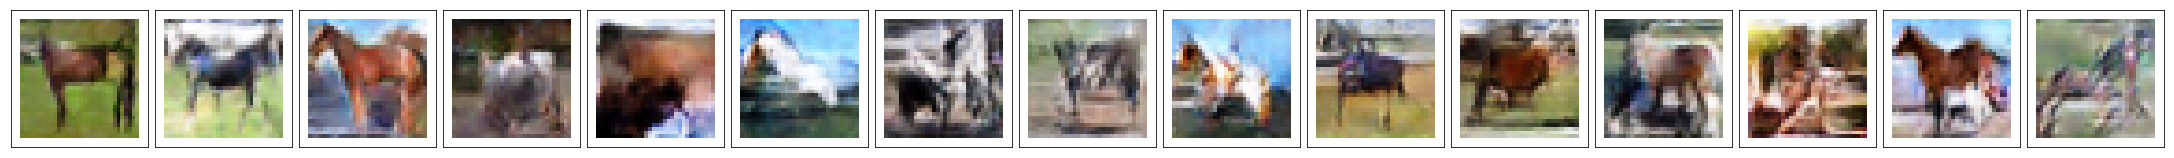

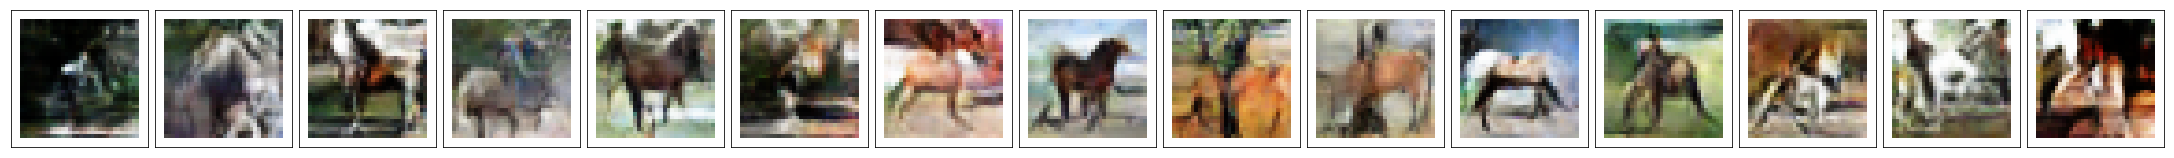

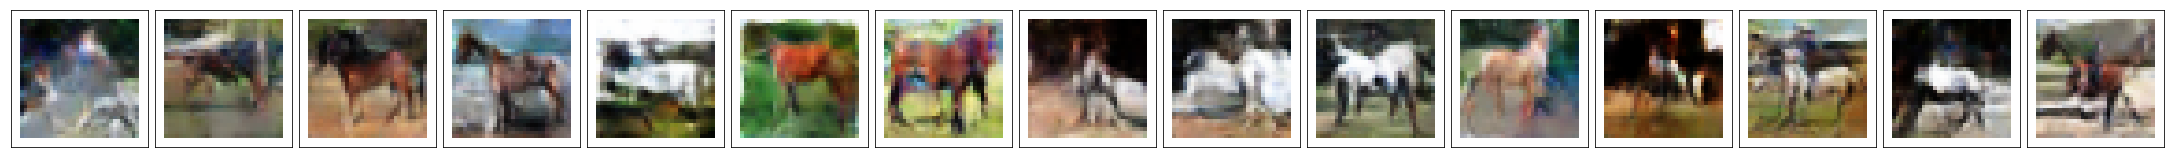

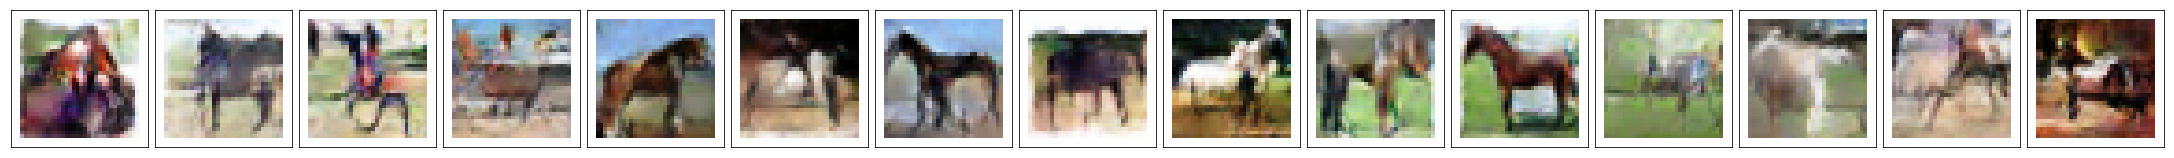

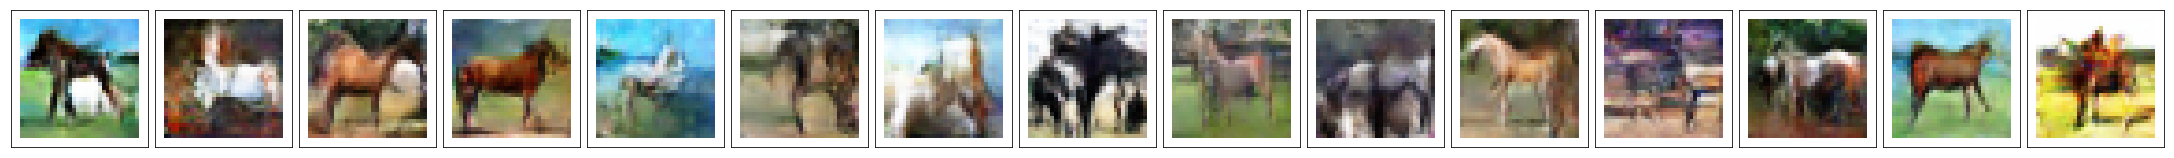

In [ ]:
with tf.Graph().as_default():
    train(noise_size, [-1, 32, 32, 3], batch_size, n_samples)